# Aug 27, 2024: mode summaries: individual estimates


In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from multiprocessing import Pool
import glob
import random

import arviz as az

from itertools import product, combinations
import multiprocessing as mp
from functools import partial

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT
import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

def set_seed(args):
    gt.seed_rng(args.SEED)
    np.random.seed(args.SEED)

set_seed(args)

In [3]:
args.type = 'spatial'
args.roi_size = 225
args.maintain_symmetry = True
args.brain_div = 'whl'
args.num_rois = 162

PARC_DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

In [4]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson-corr'
args.THRESHOLDING = f'positive'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 10
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'ses'

BASE_path = f'{os.environ["HOME"]}/mouse_dataset/roi_results_v2'
ROI_path = f'{BASE_path}/{PARC_DESC}'
TS_path = f'{ROI_path}/runwise_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLDING}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [5]:
def plot_mode_summaries(args, SBM, modes_df, sub):
    nrows = 1
    ncols = 4
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 4*nrows), dpi=90)
    fig.tight_layout(h_pad=3, w_pad=2)

    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
    cmap = cc.cm.CET_L12
    titles = [f'sub-{sub}_{SBM}']
    ylabels = ['mode size, $\omega_k$', 'uncertainty, $\sigma_k$', 'ratio, $\omega_k$ / $\sigma_k$']
    cols = ['omega', 'sigma', 'ratio']

    for idx in range(len(cols)):
        ax = axs[idx]
        col = cols[idx]
        # change rescaling colors to max to 0.0
        cs = cmap(rescale(modes_df[col])) if len(modes_df[col]) > 1 else cmap(rescale(modes_df[col].to_list() + [0.0]))
        sns.barplot(modes_df, x='mode_id', y=col, ax=ax, palette=cs, width=0.9)
        ax.set(ylabel=ylabels[idx], xlabel='mode $k$')
        if idx == 0: ax.set(title=titles[0])
    
    # cdf of omega's
    ax = axs[ncols-1]
    vals = list(np.cumsum(modes_df['omega'].to_list()))
    cs = cmap(rescale(vals)) if len(vals) > 1 else cmap(rescale(vals + [0.0]))
    sns.barplot(vals, ax=ax, palette=cs, width=0.9)
    idxs = [i for i, v in enumerate(vals) if v >= 0.95]
    idx = idxs[1] if len(idxs) > 1 else idxs[0]
    ymin, ymax = ax.get_ylim()
    ax.axvline(x=idx, ymin=ymin, ymax=ymax, color='lightcoral', linewidth=3, linestyle='--')
    ax.axhline(y=0.95, xmin=0, xmax=len(vals), color='lightcoral', linewidth=3, linestyle='--')
    ax.set(ylabel='cdf of $\omega_k$', xlabel='mode $k$')
    
    return fig, idx

In [6]:
sbms_list = [
    (True, 'a'),
    (True, 'd'),
    (True, 'h'),
    (False, 'd'),
    (False, 'h'),
]

sbm--a


['/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-10/layer-individual/unit-ses/estimates/individual/sub-SLC01/partition-modes-group-aligned/sbm--a/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-10/layer-individual/unit-ses/estimates/individual/sub-SLC02/partition-modes-group-aligned/sbm--a/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-10/layer-individual/unit-ses/estimates/individual/sub-SLC03/partition-modes-group-aligned/sbm--a/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/gr

100%|██████████| 10/10 [00:05<00:00,  1.78it/s]

sbm-dc-d


['/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-10/layer-individual/unit-ses/estimates/individual/sub-SLC01/partition-modes-group-aligned/sbm-dc-d/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-10/layer-individual/unit-ses/estimates/individual/sub-SLC02/partition-modes-group-aligned/sbm-dc-d/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-10/layer-individual/unit-ses/estimates/individual/sub-SLC03/partition-modes-group-aligned/sbm-dc-d/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-

100%|██████████| 10/10 [00:06<00:00,  1.59it/s]

sbm-dc-h


['/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-10/layer-individual/unit-ses/estimates/individual/sub-SLC01/partition-modes-group-aligned/sbm-dc-h/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-10/layer-individual/unit-ses/estimates/individual/sub-SLC02/partition-modes-group-aligned/sbm-dc-h/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-10/layer-individual/unit-ses/estimates/individual/sub-SLC03/partition-modes-group-aligned/sbm-dc-h/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-

100%|██████████| 10/10 [00:05<00:00,  1.76it/s]

sbm-nd-d


['/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-10/layer-individual/unit-ses/estimates/individual/sub-SLC01/partition-modes-group-aligned/sbm-nd-d/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-10/layer-individual/unit-ses/estimates/individual/sub-SLC02/partition-modes-group-aligned/sbm-nd-d/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-10/layer-individual/unit-ses/estimates/individual/sub-SLC03/partition-modes-group-aligned/sbm-nd-d/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-

100%|██████████| 10/10 [00:05<00:00,  1.70it/s]

sbm-nd-h


['/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-10/layer-individual/unit-ses/estimates/individual/sub-SLC01/partition-modes-group-aligned/sbm-nd-h/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-10/layer-individual/unit-ses/estimates/individual/sub-SLC02/partition-modes-group-aligned/sbm-nd-h/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-10/layer-individual/unit-ses/estimates/individual/sub-SLC03/partition-modes-group-aligned/sbm-nd-h/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-

100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


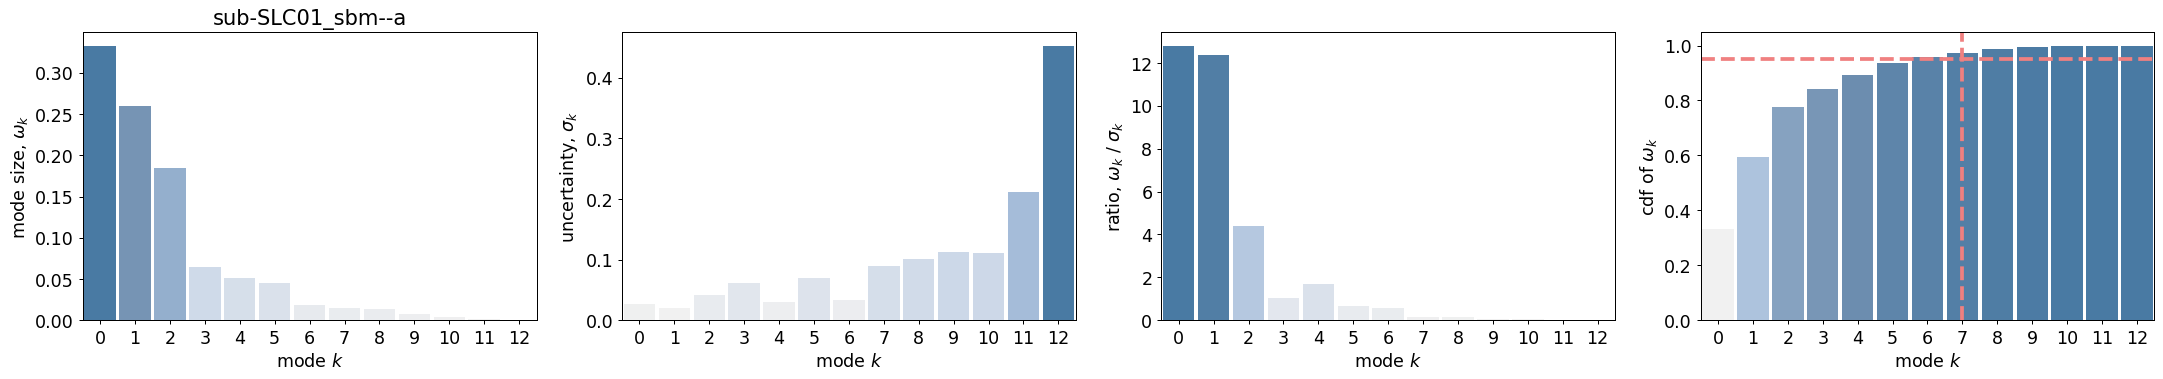

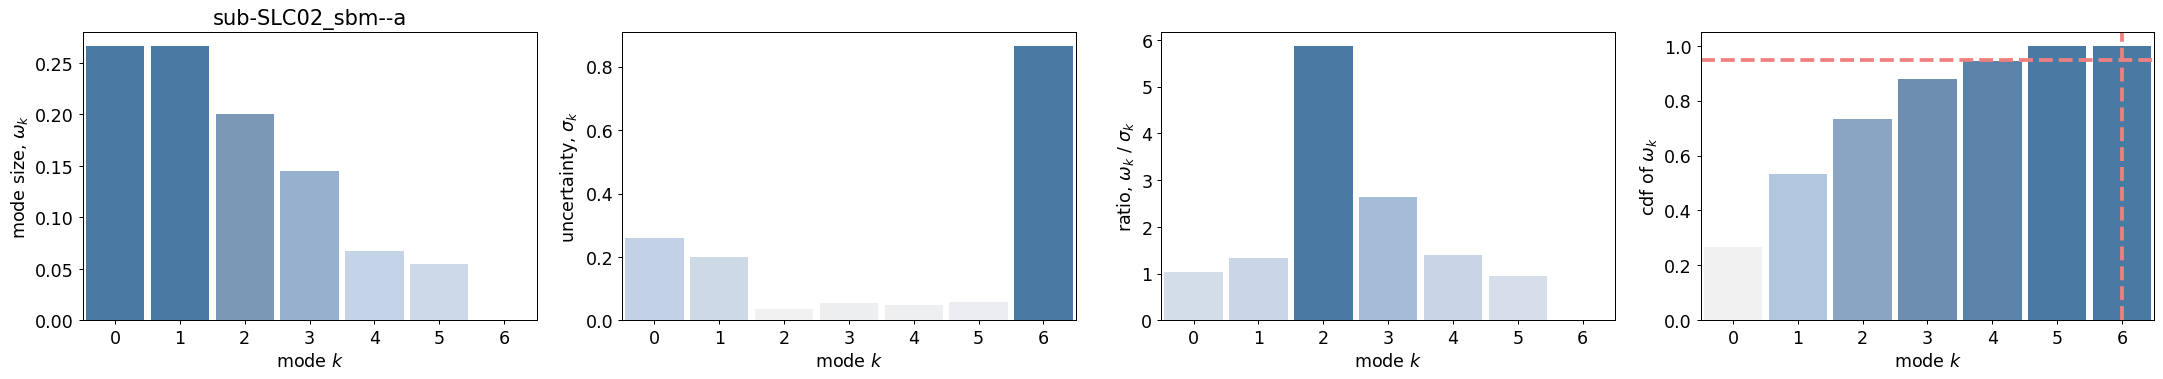

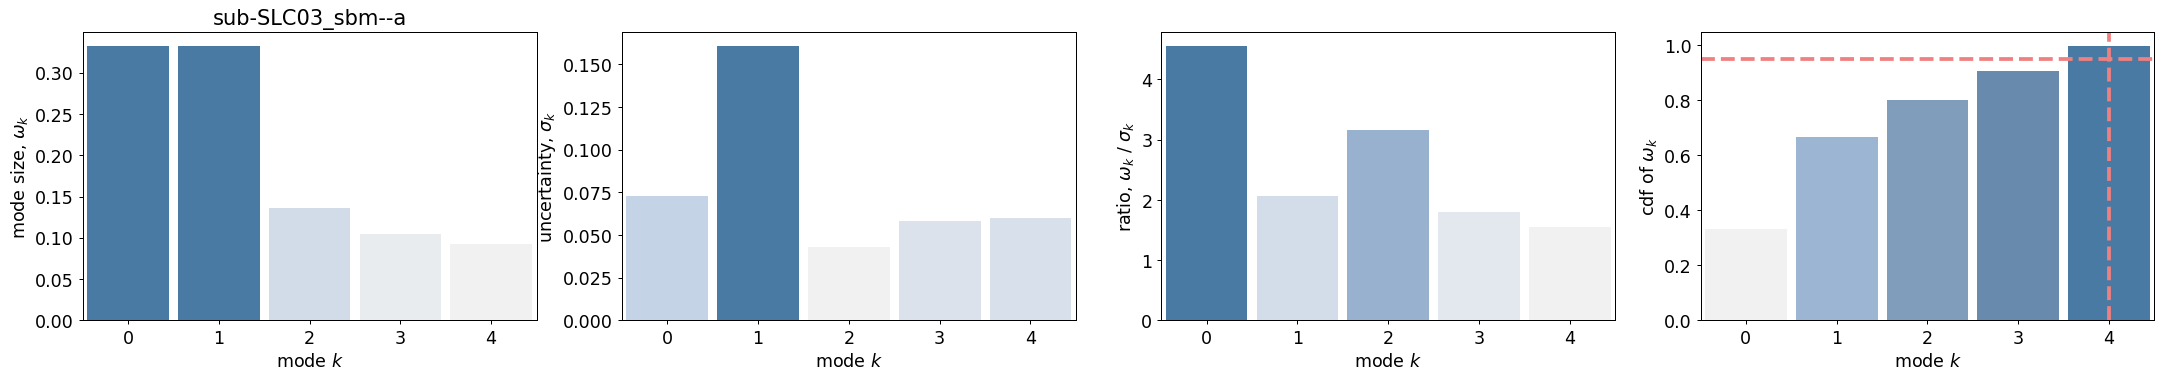

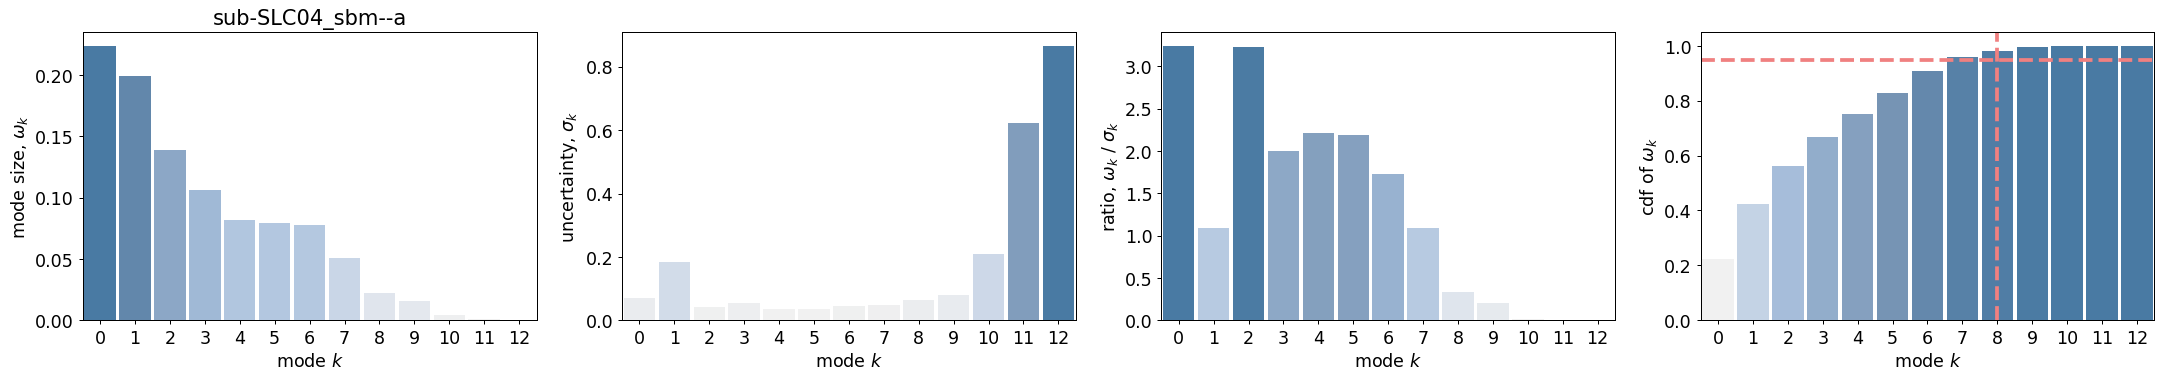

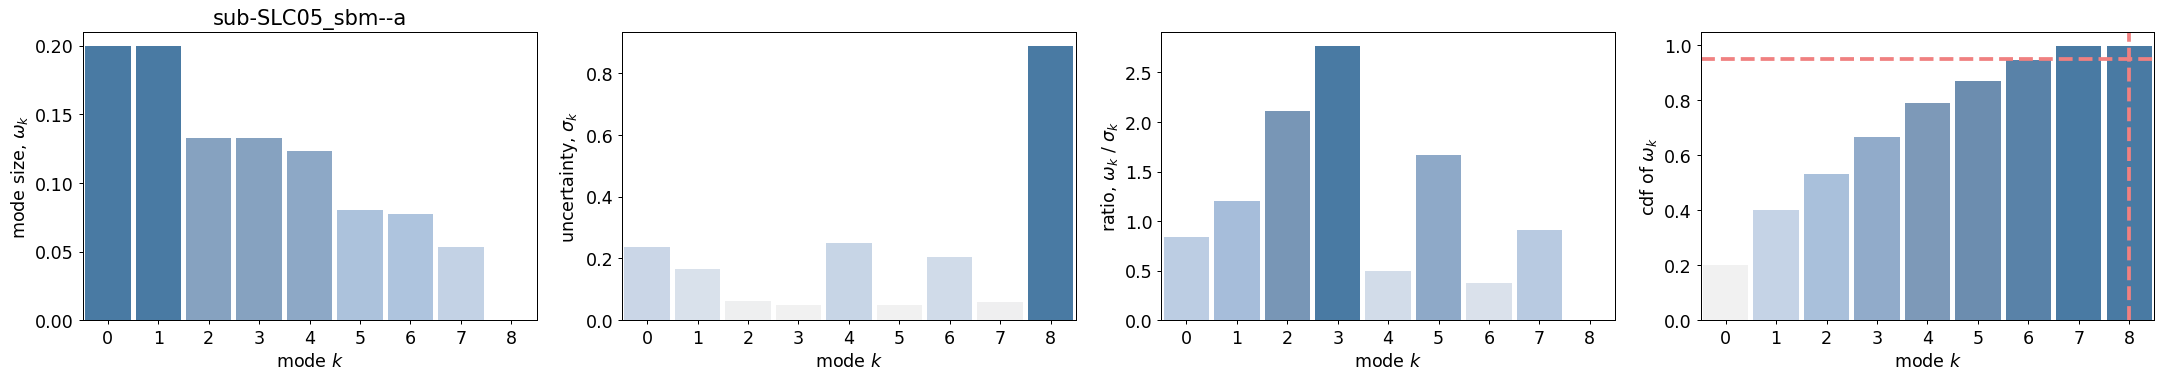

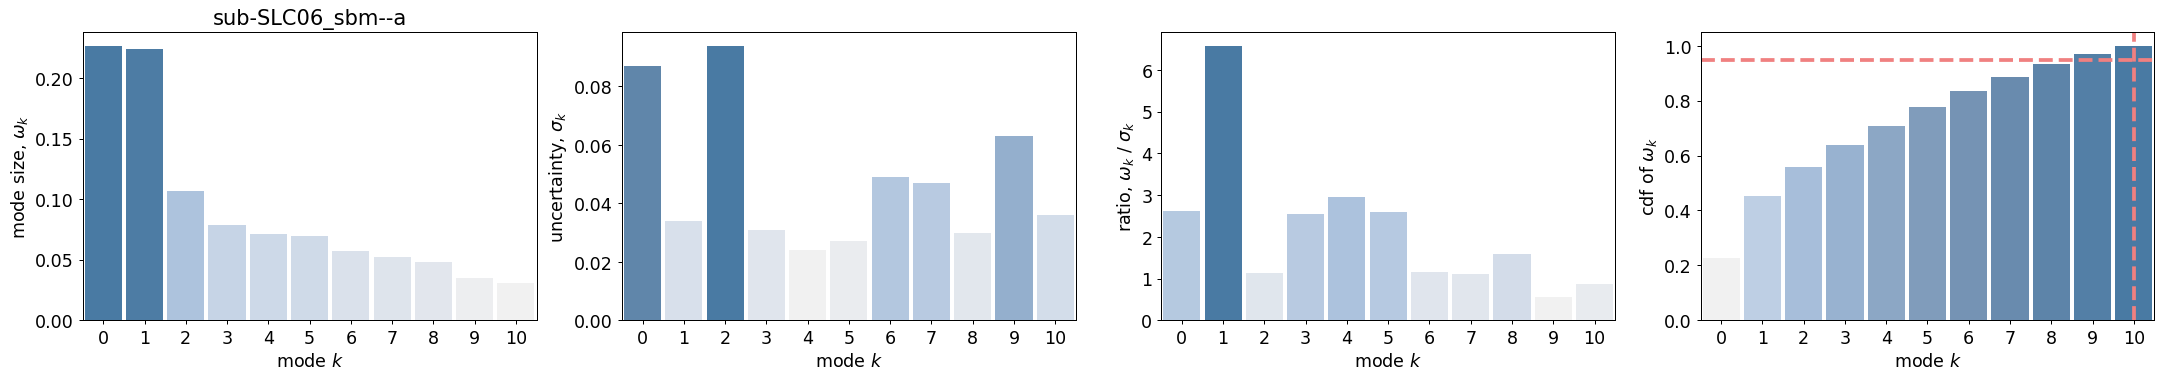

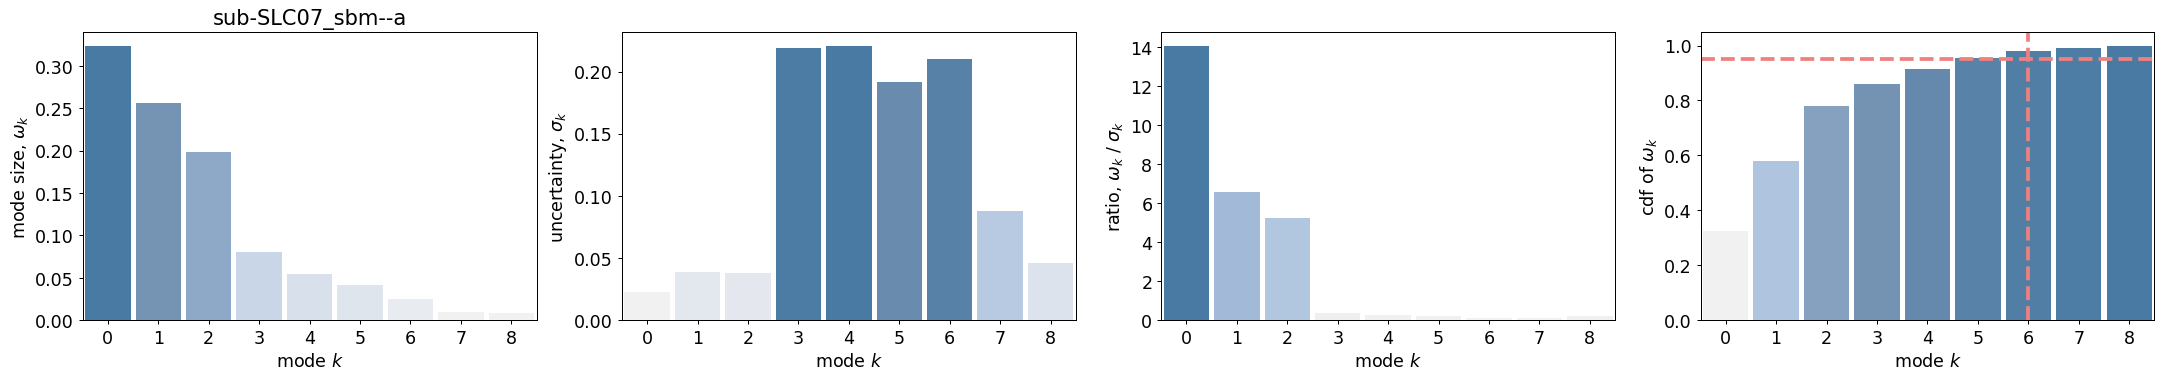

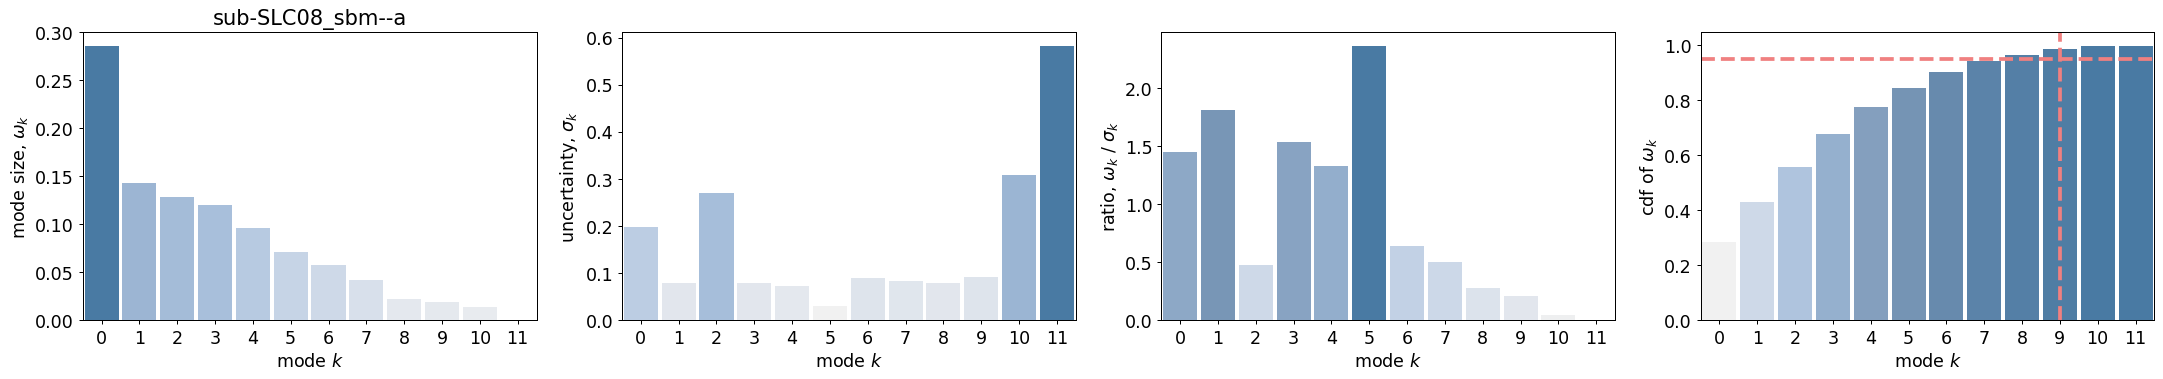

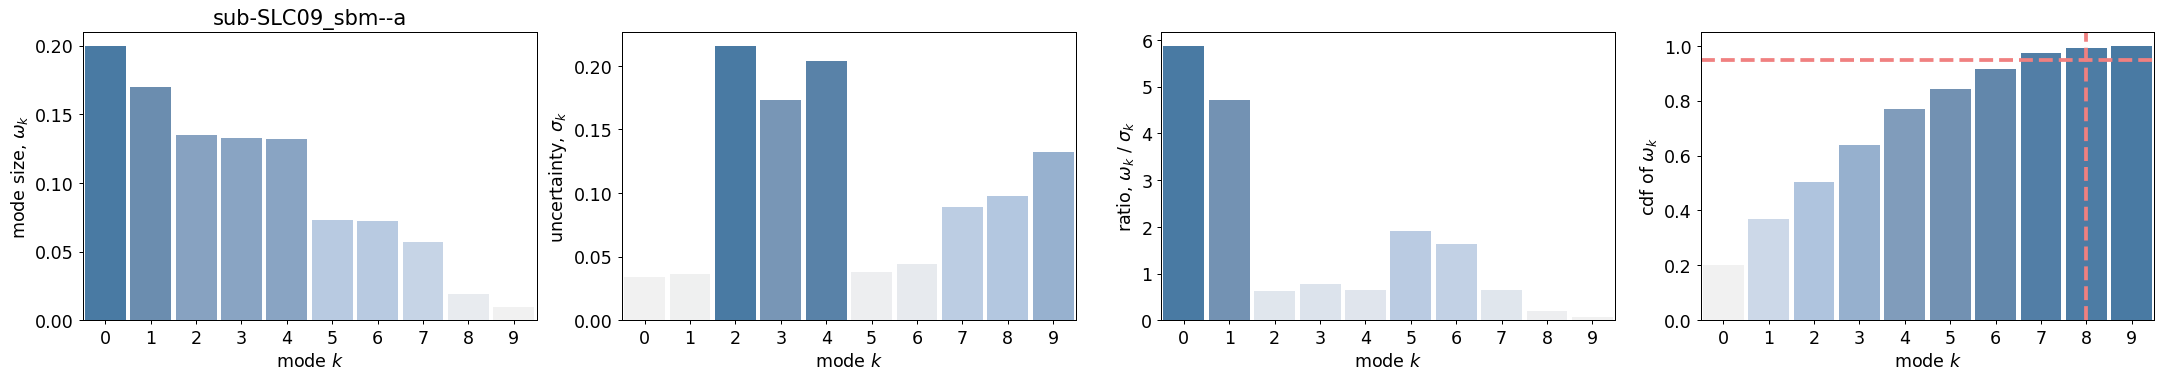

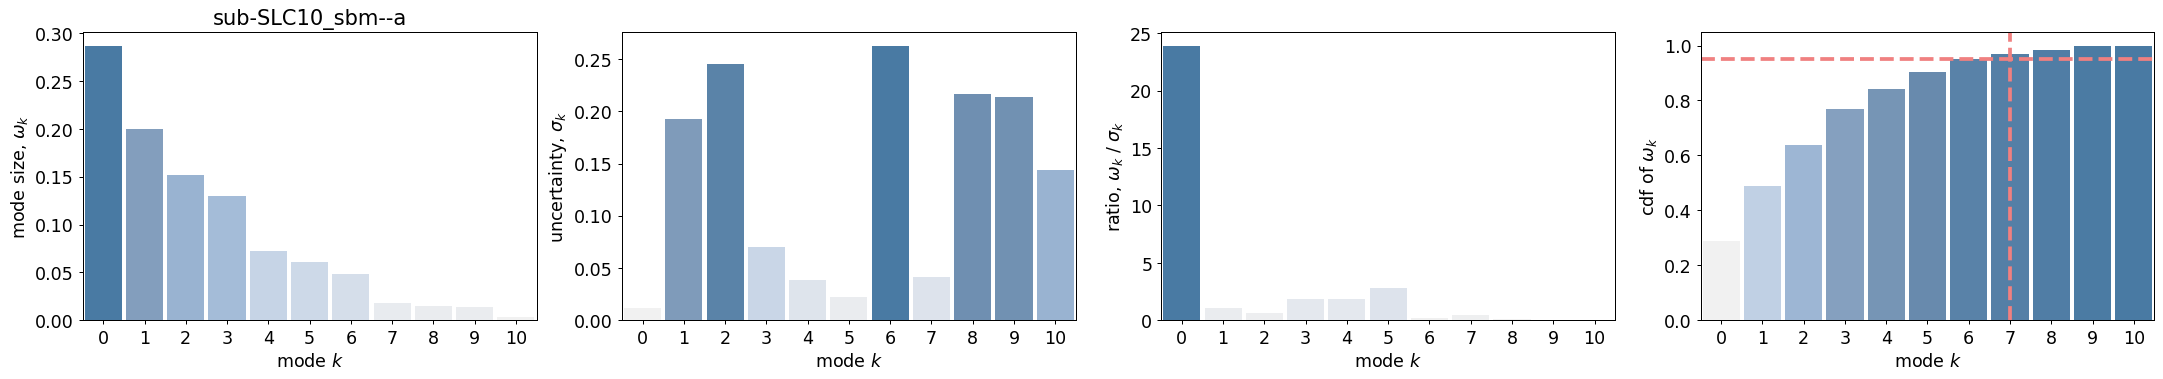

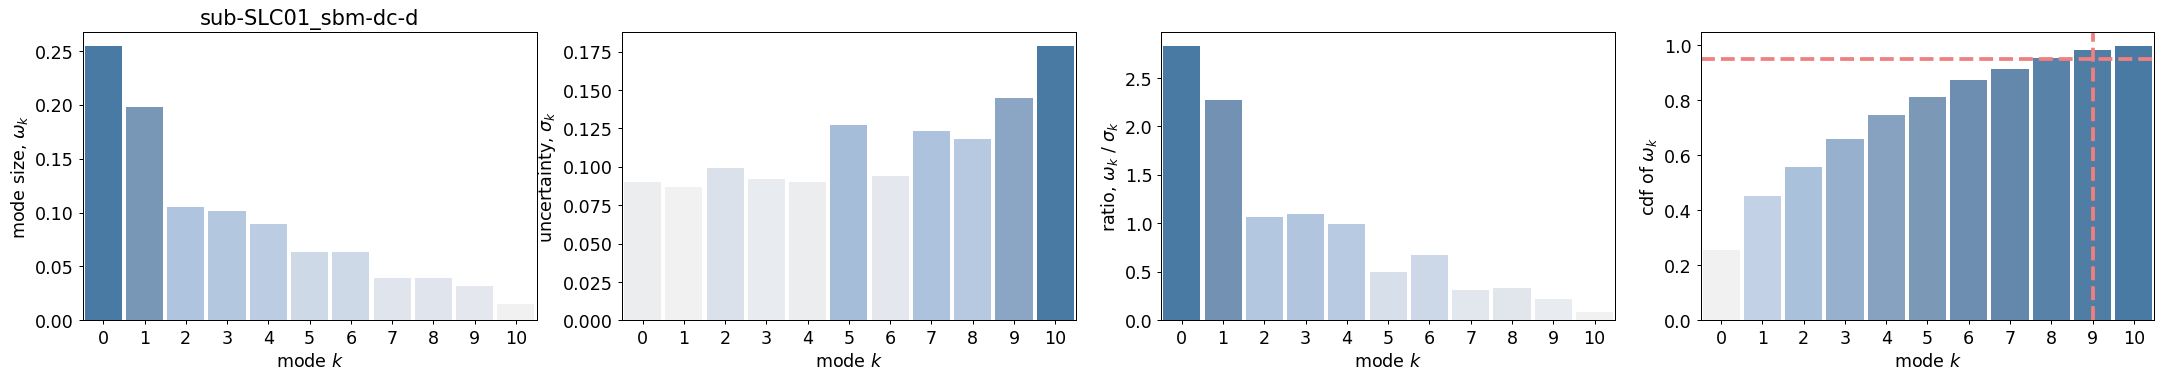

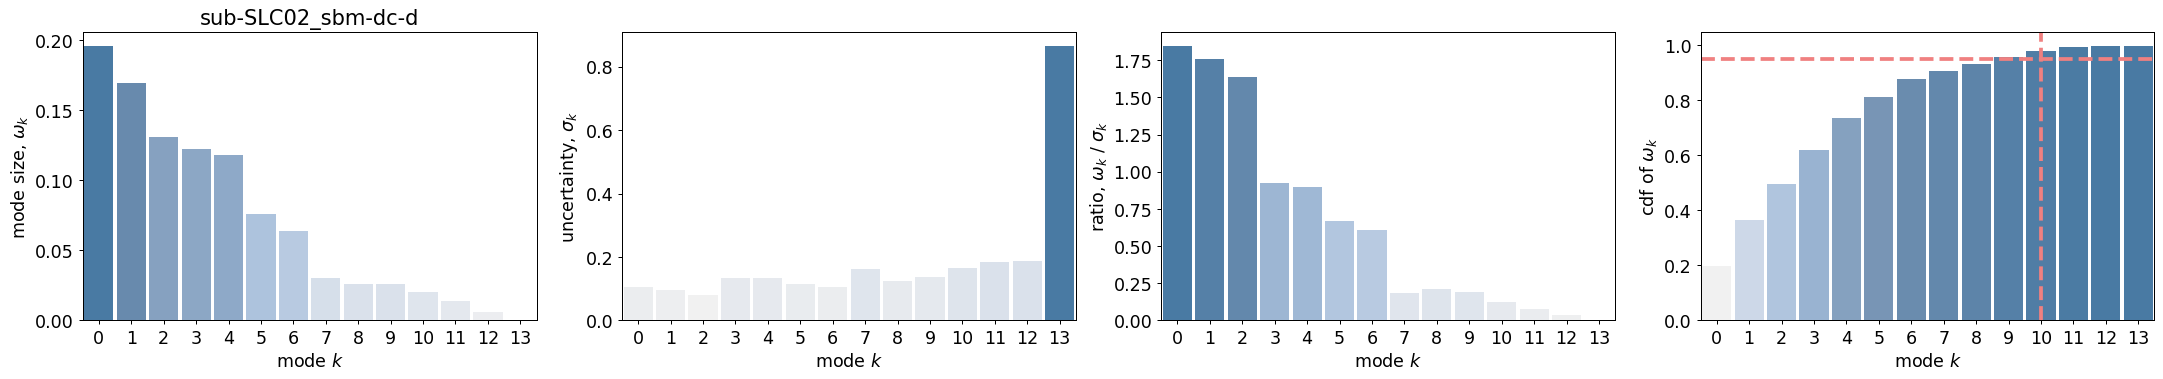

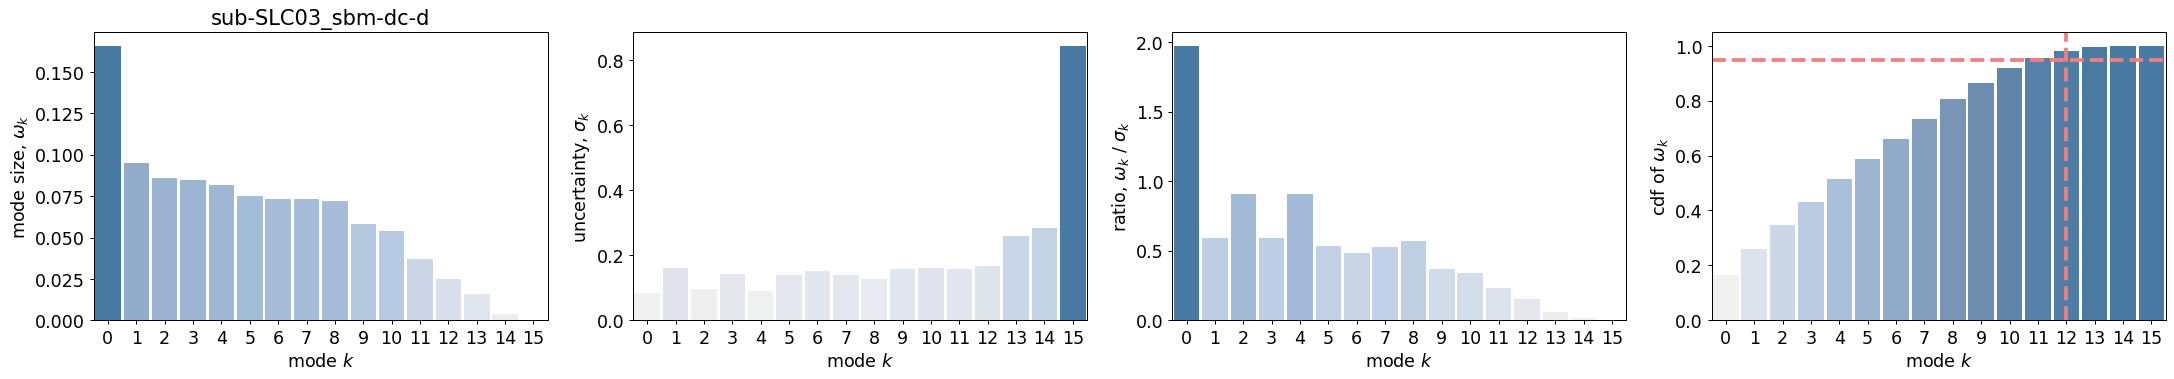

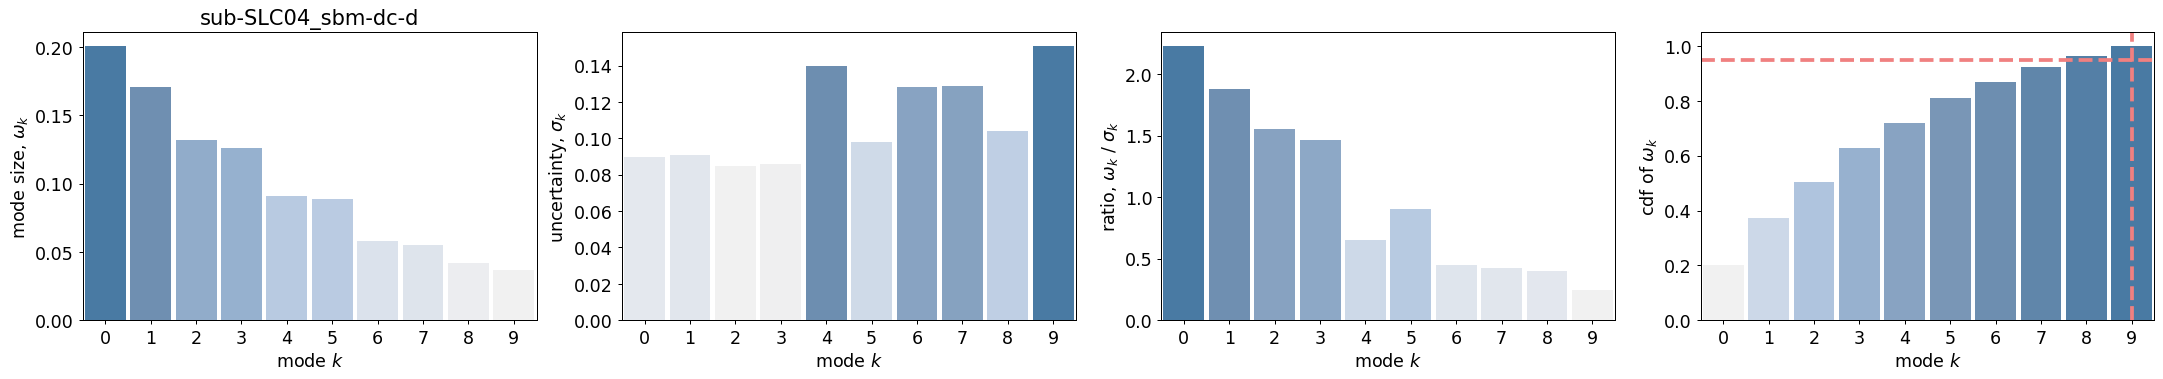

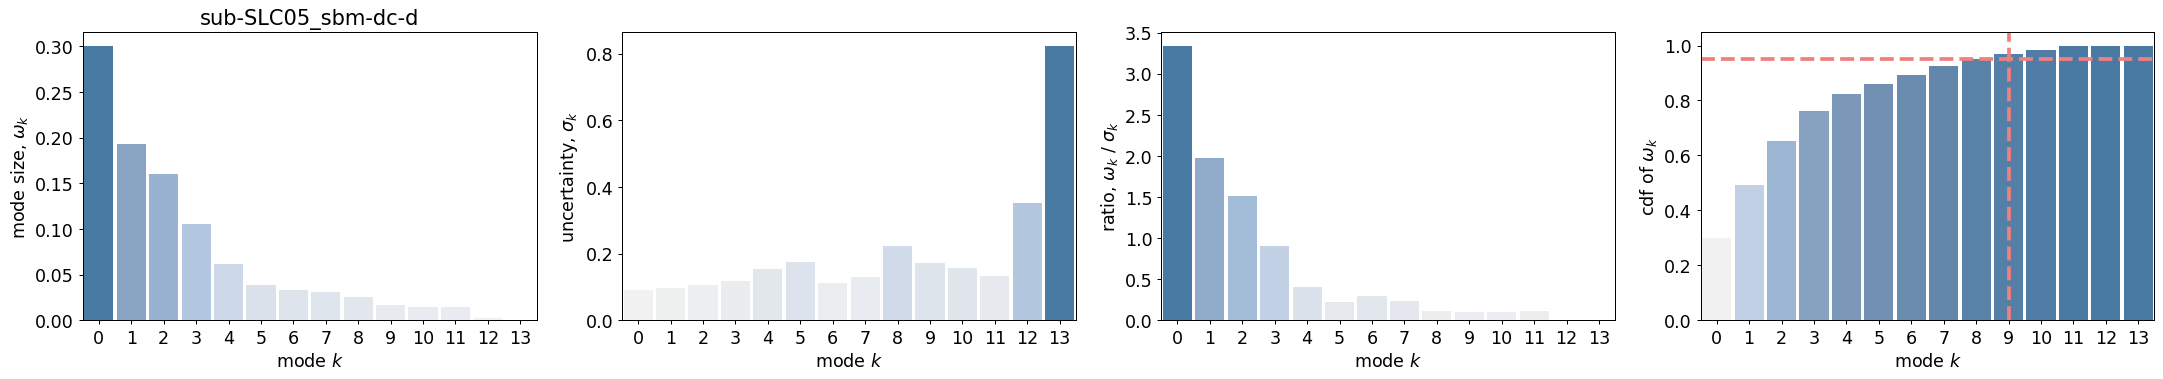

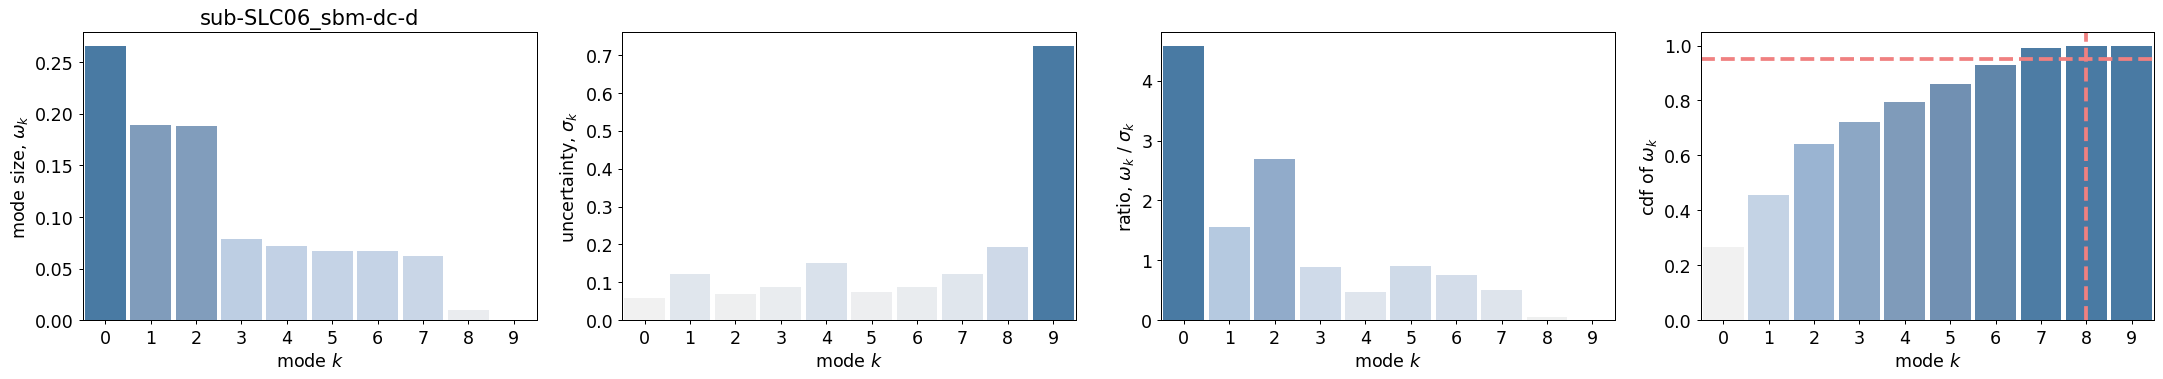

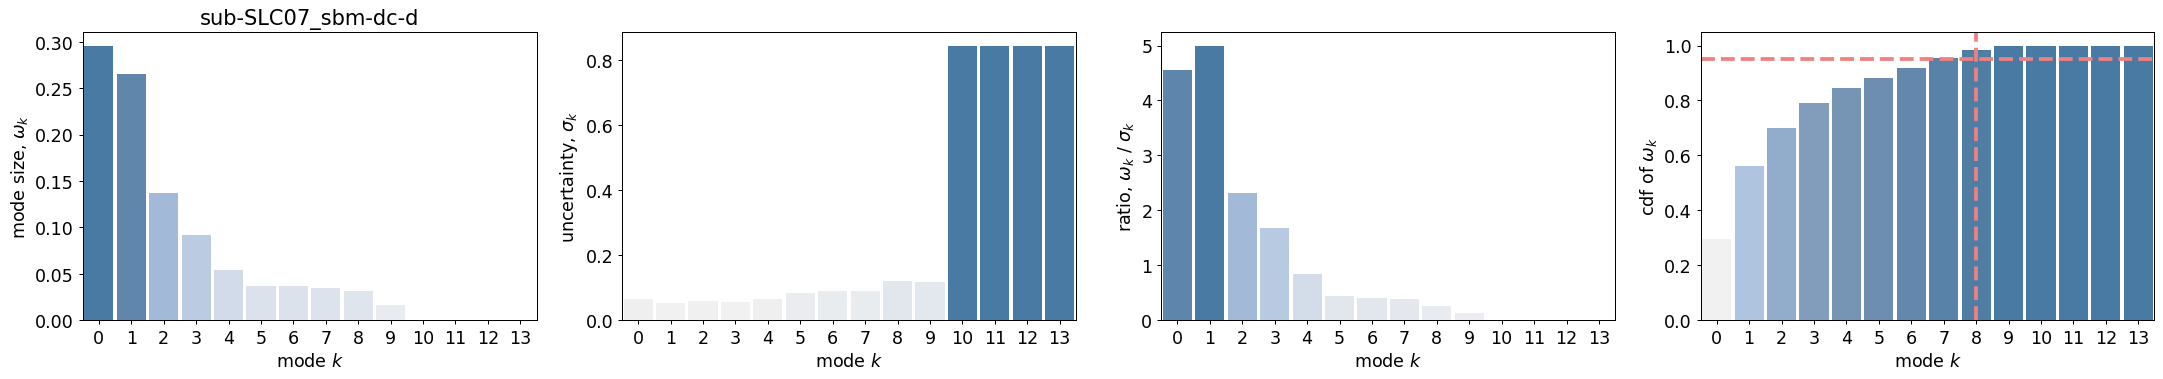

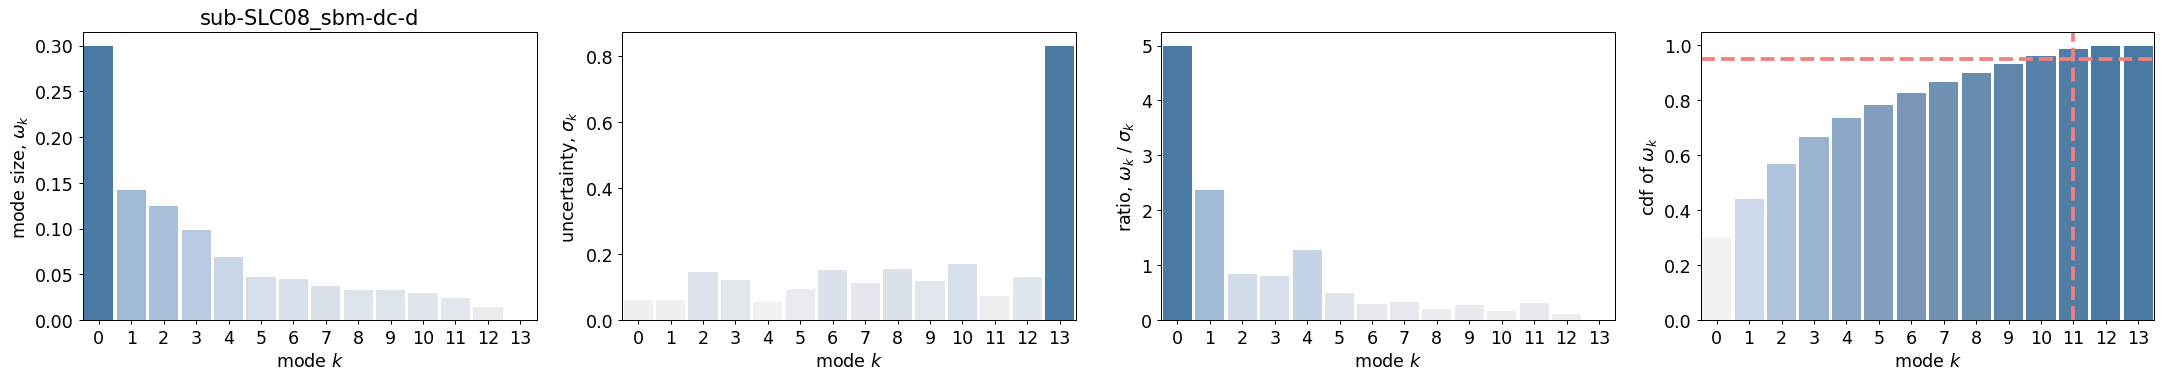

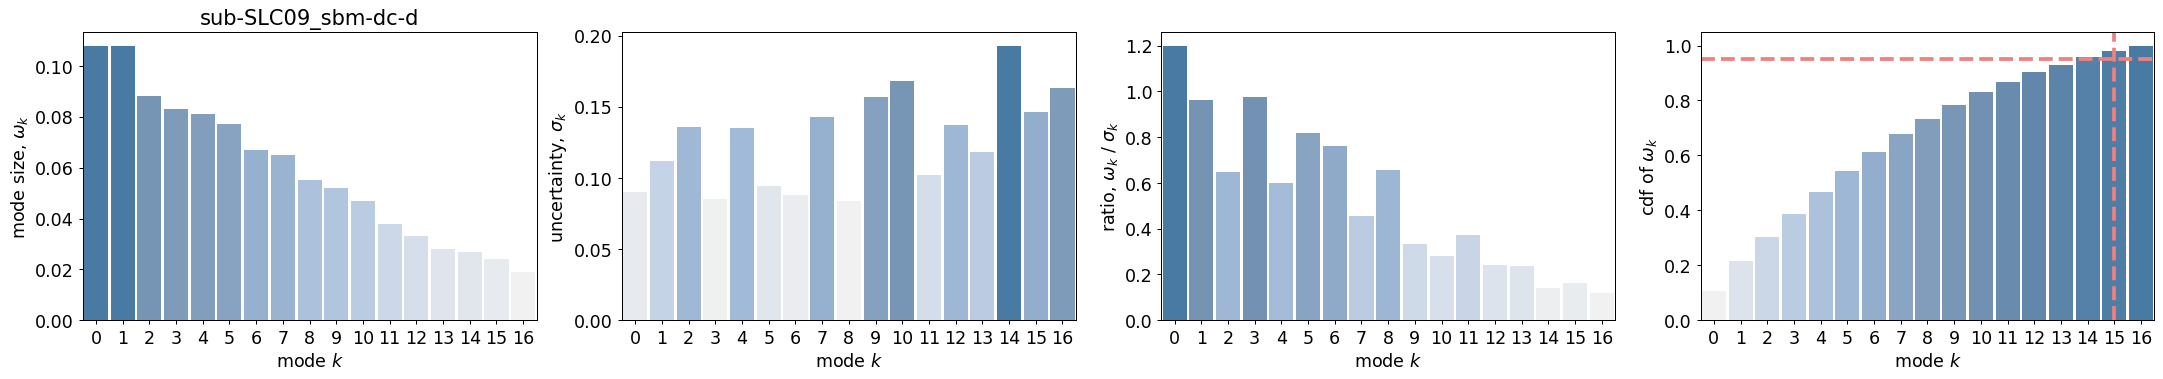

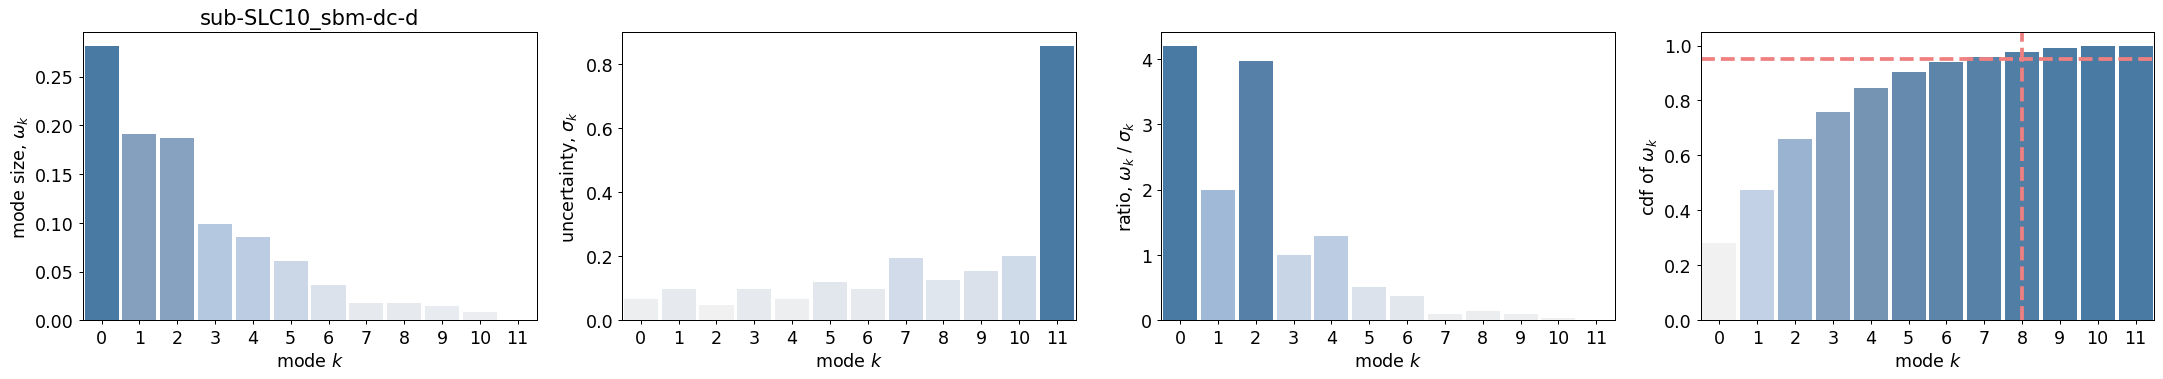

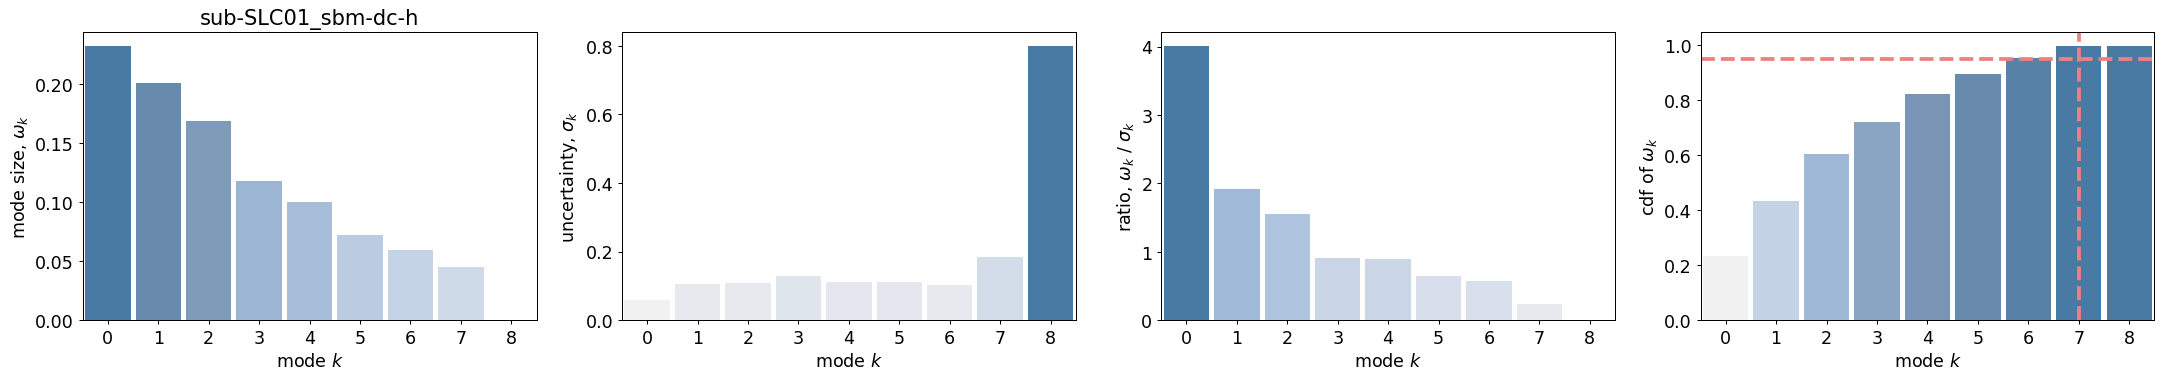

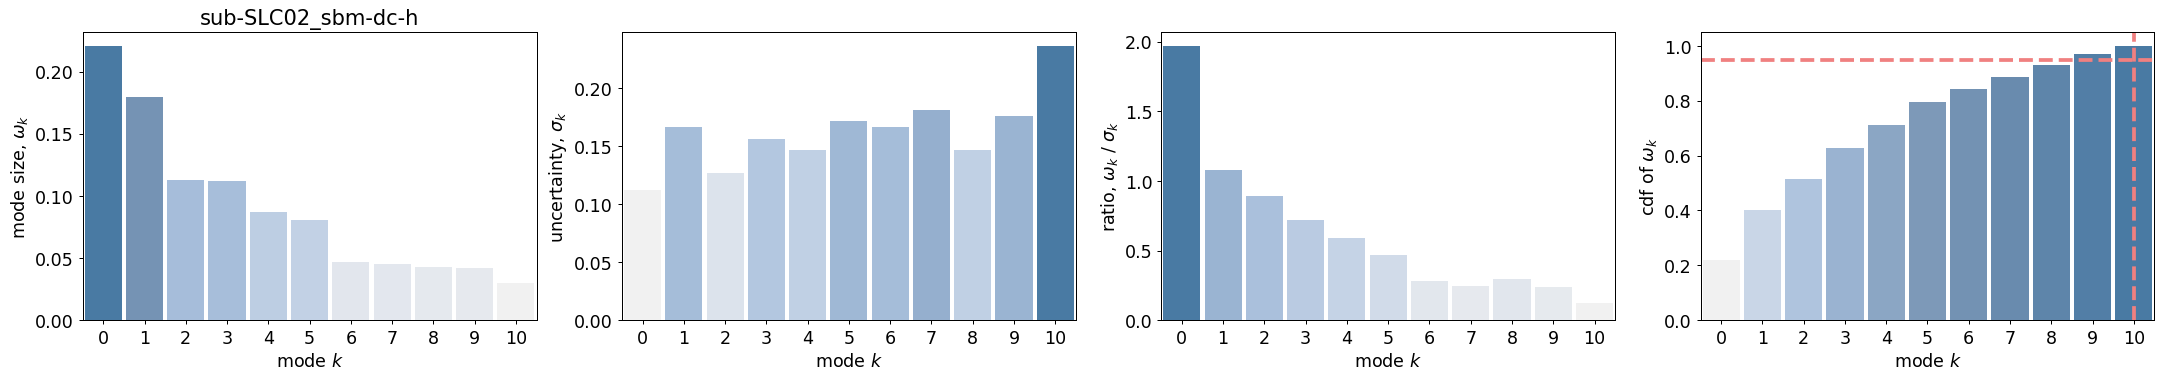

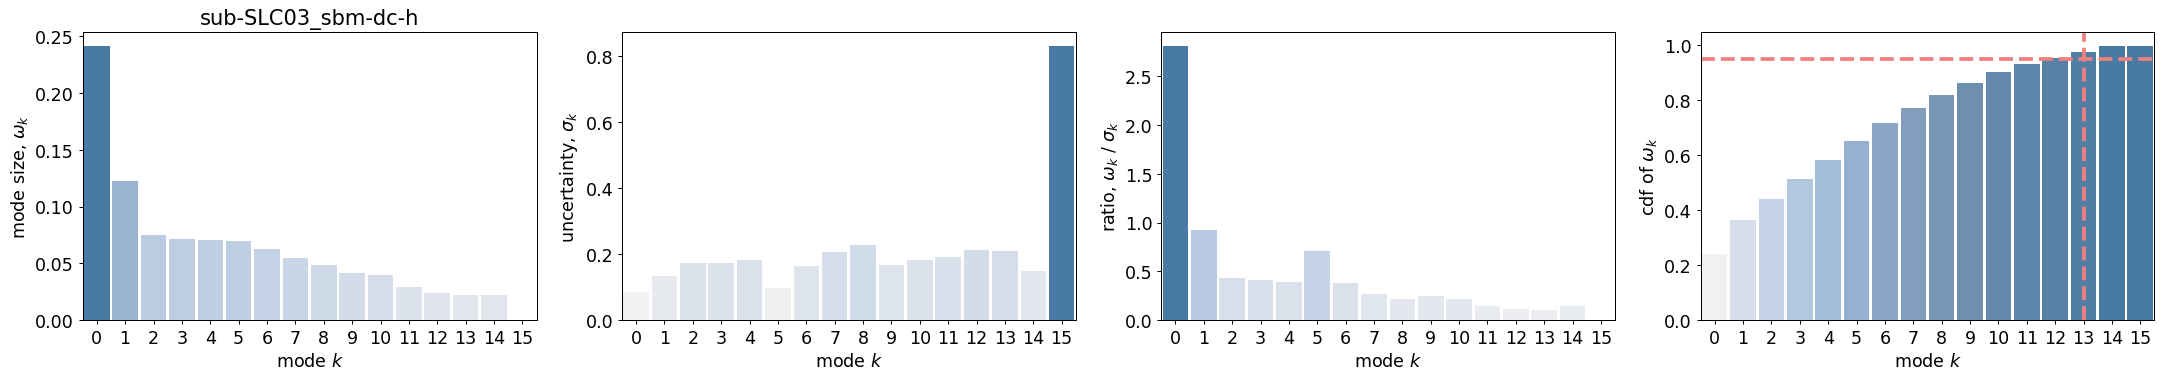

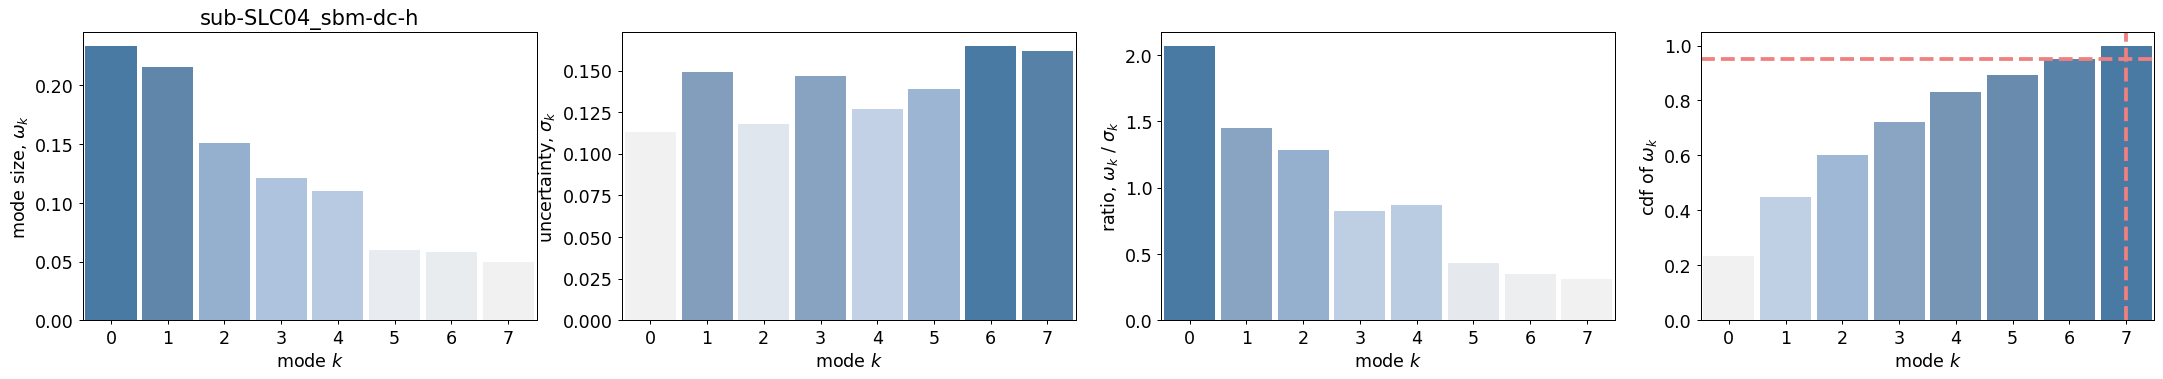

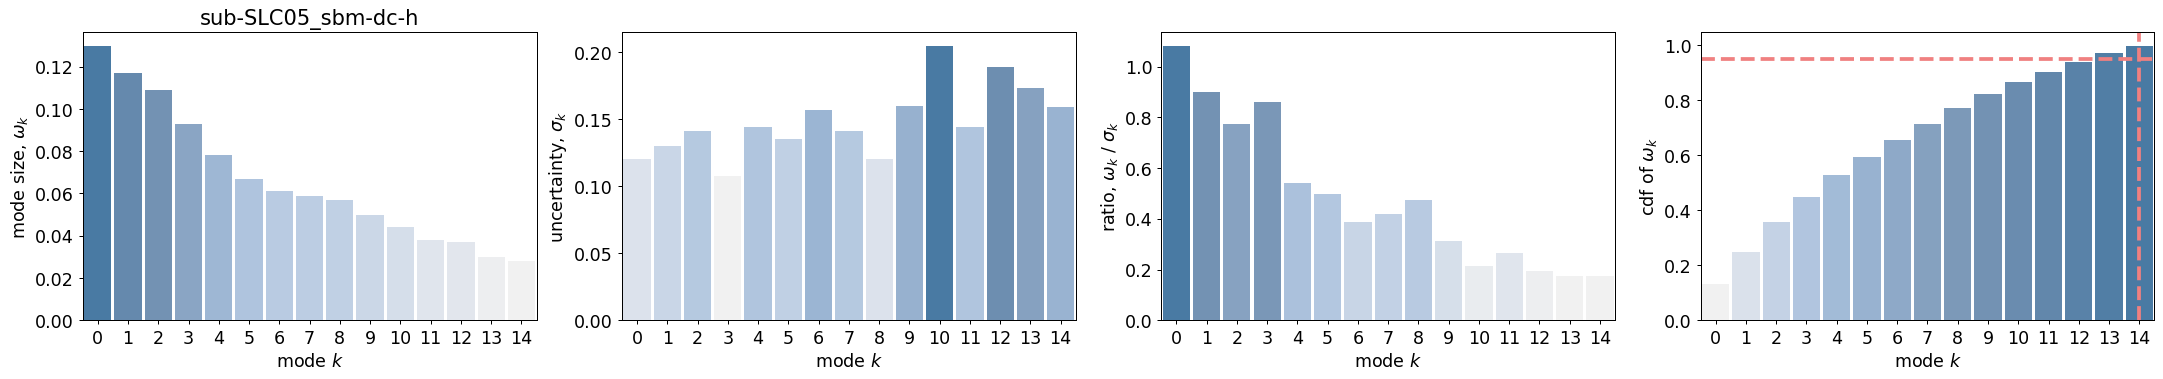

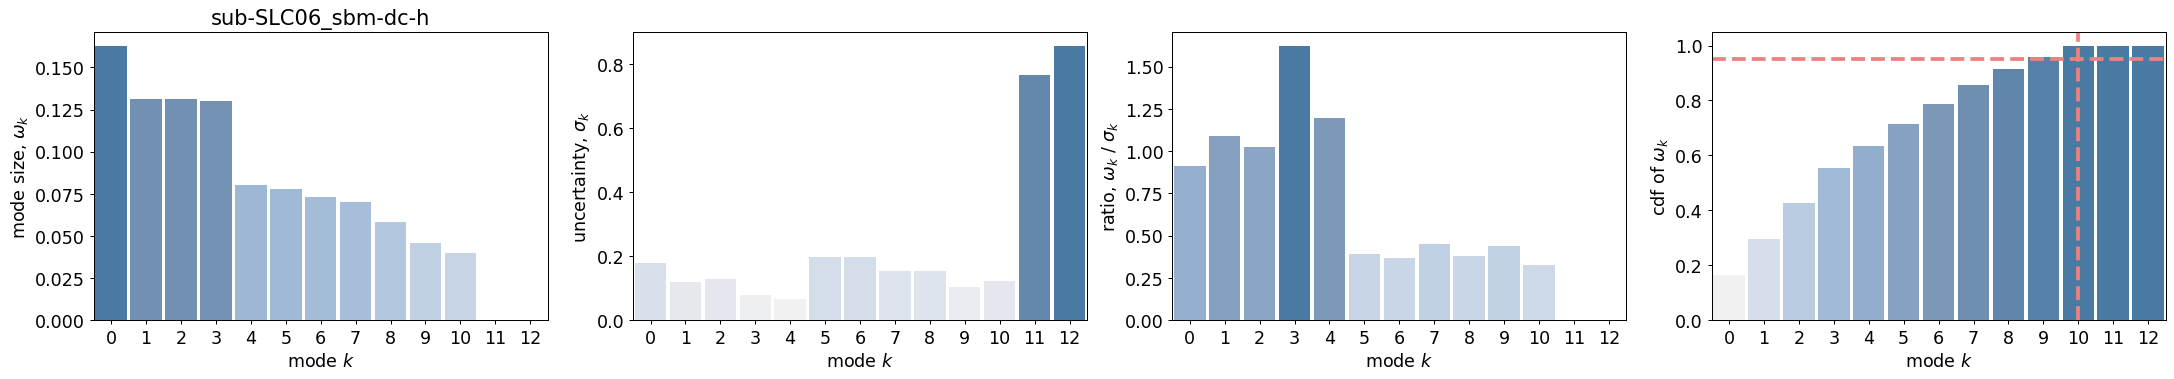

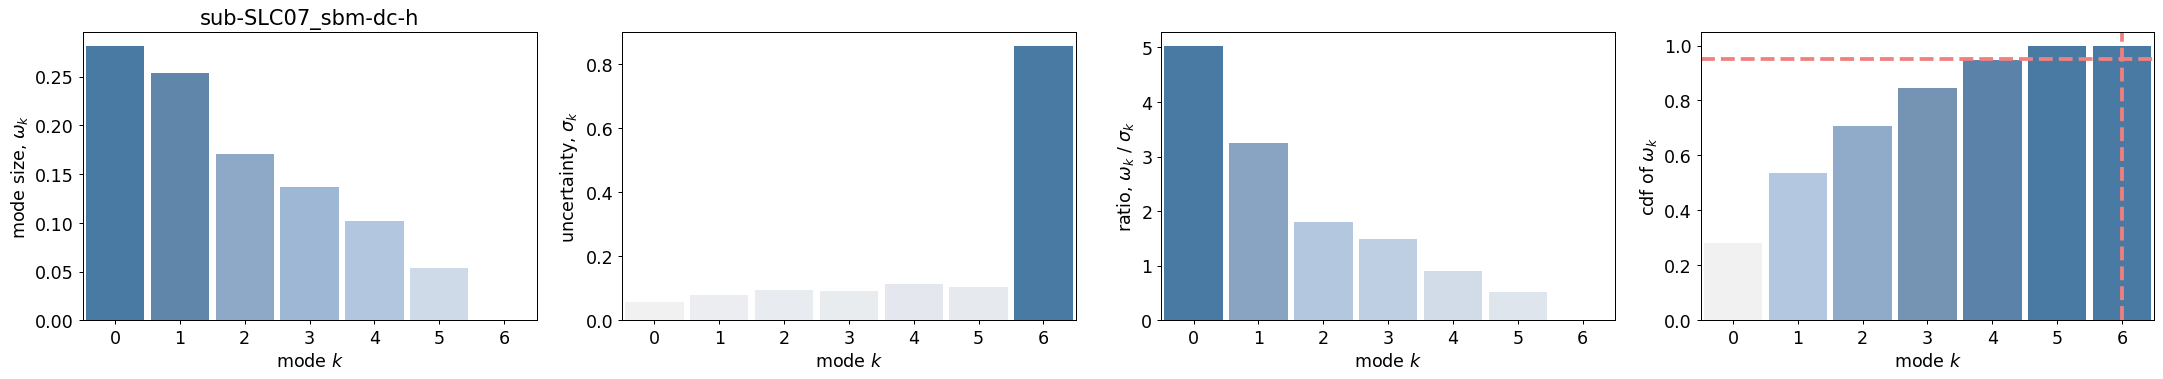

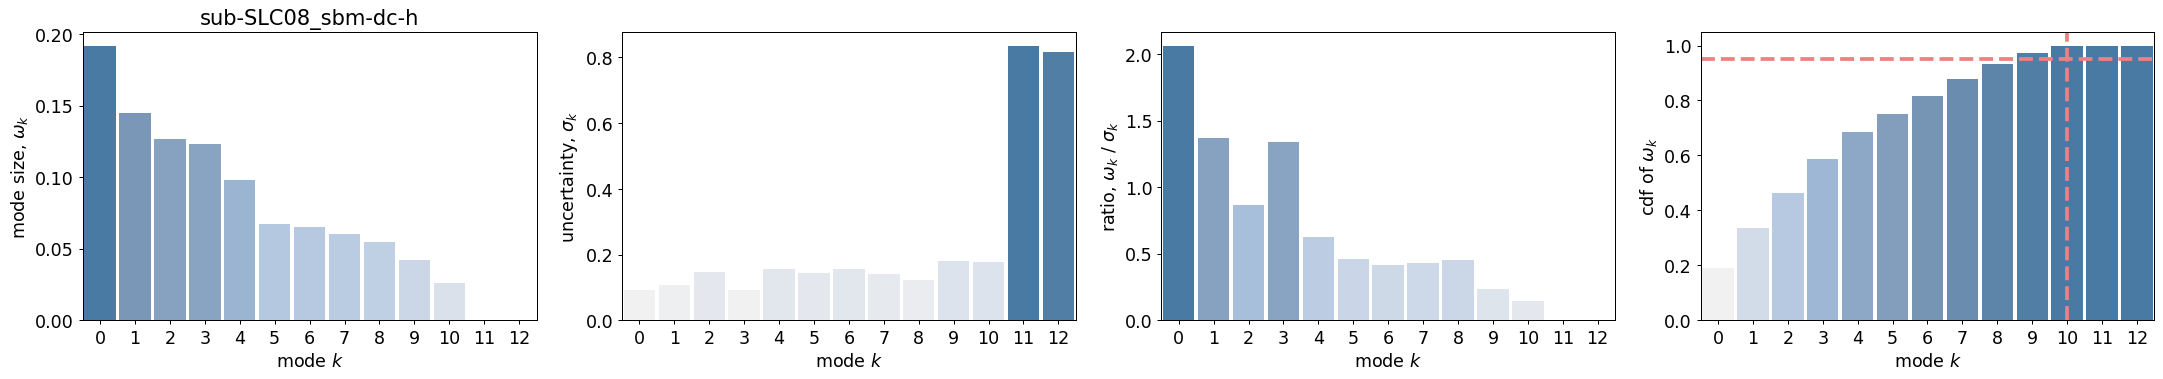

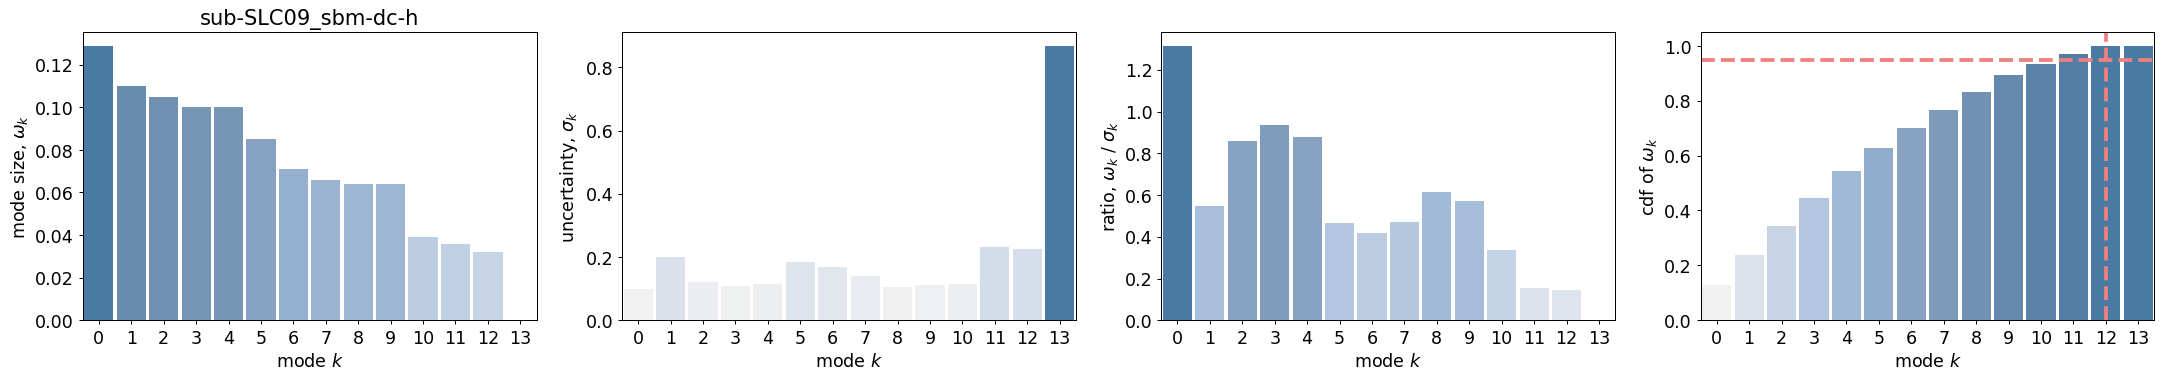

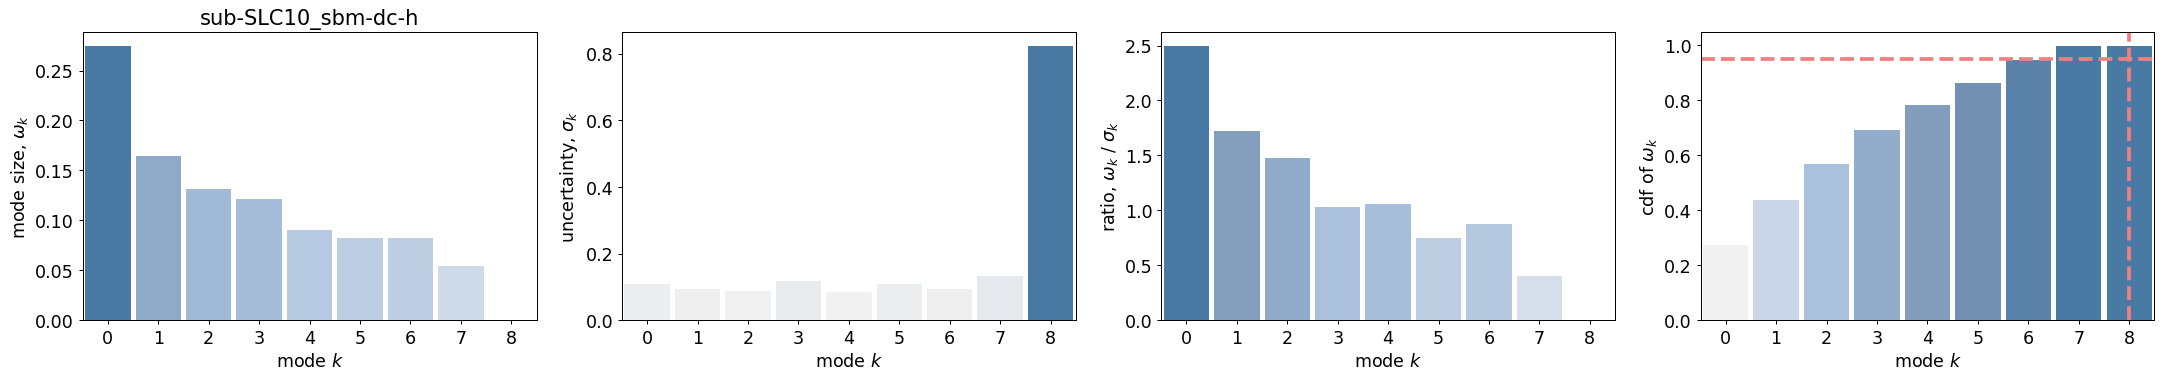

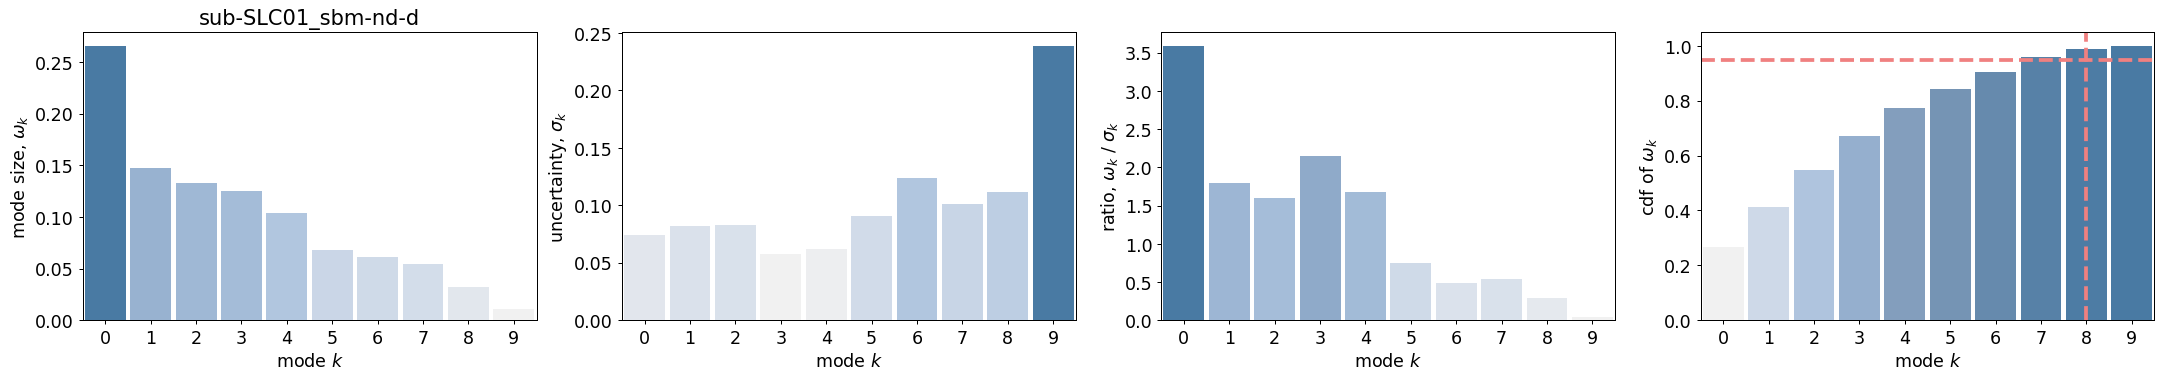

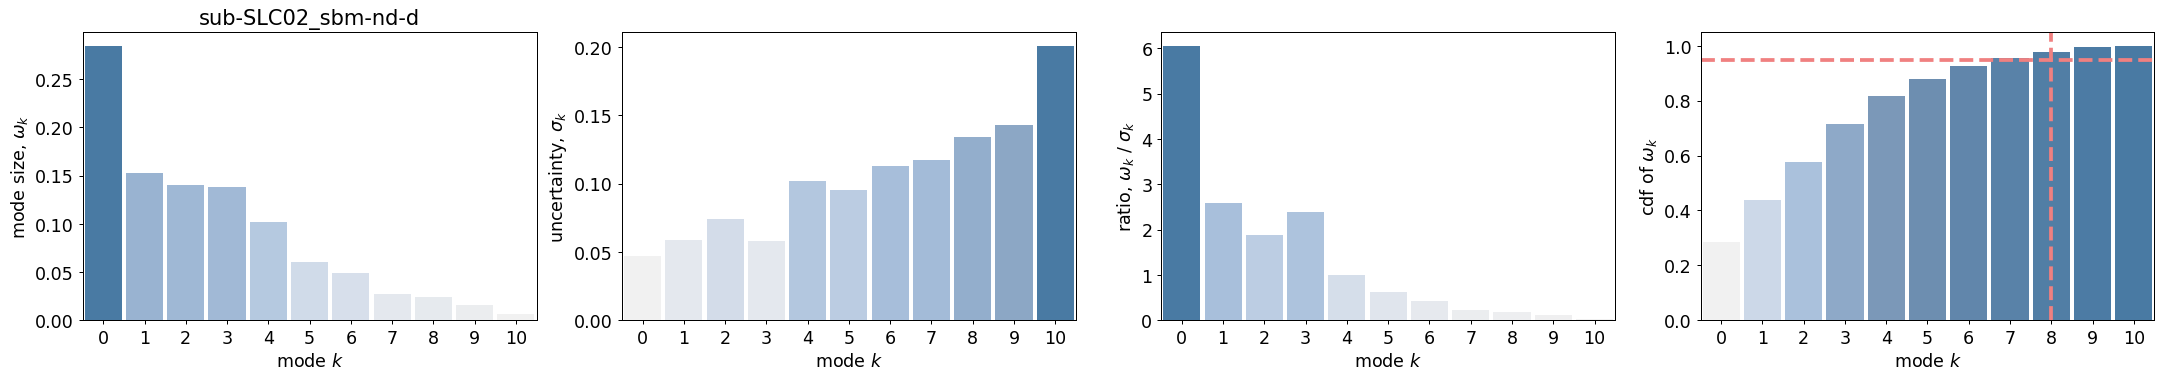

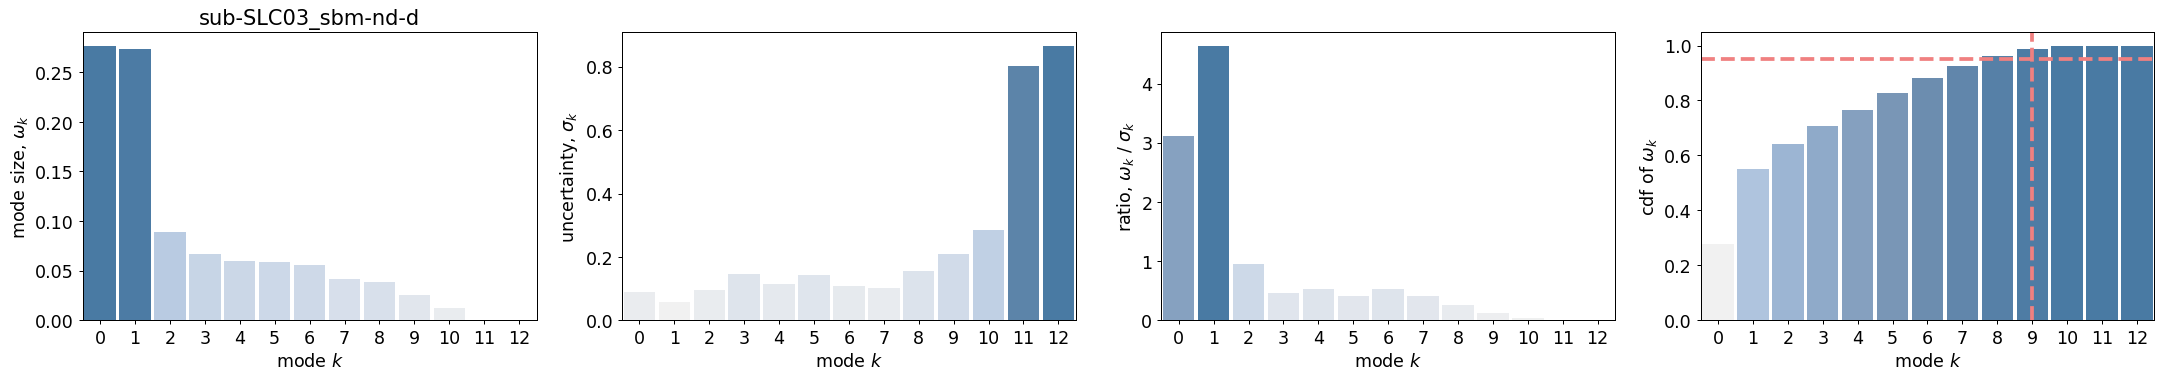

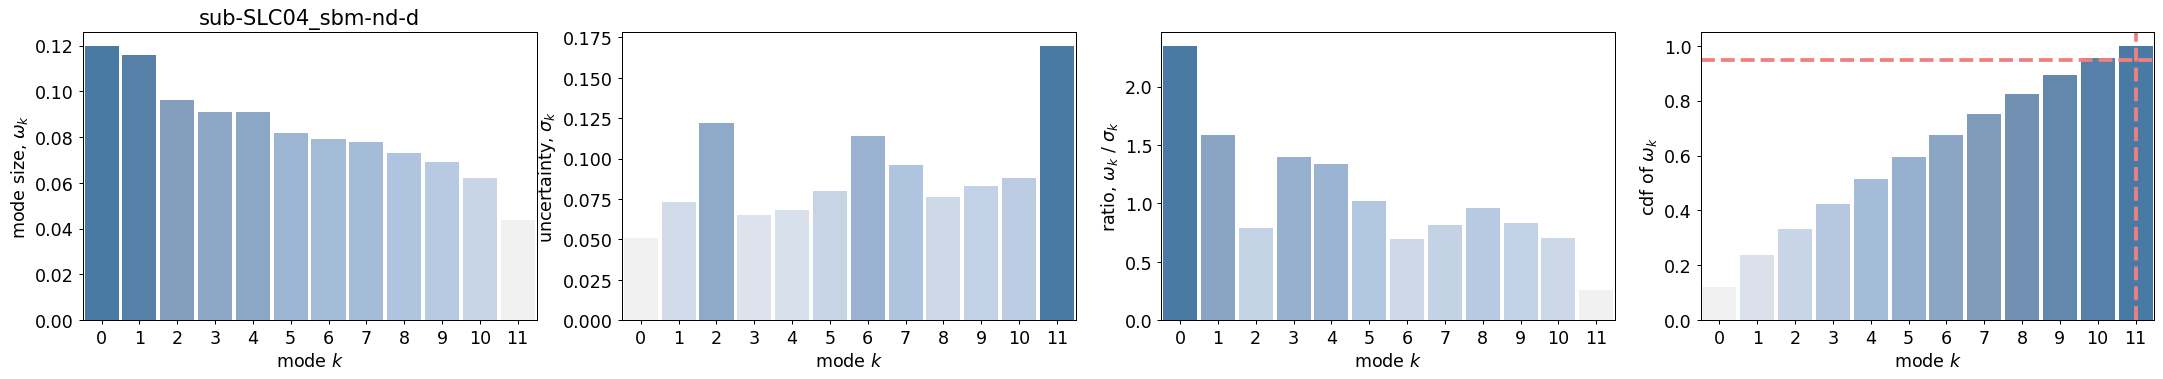

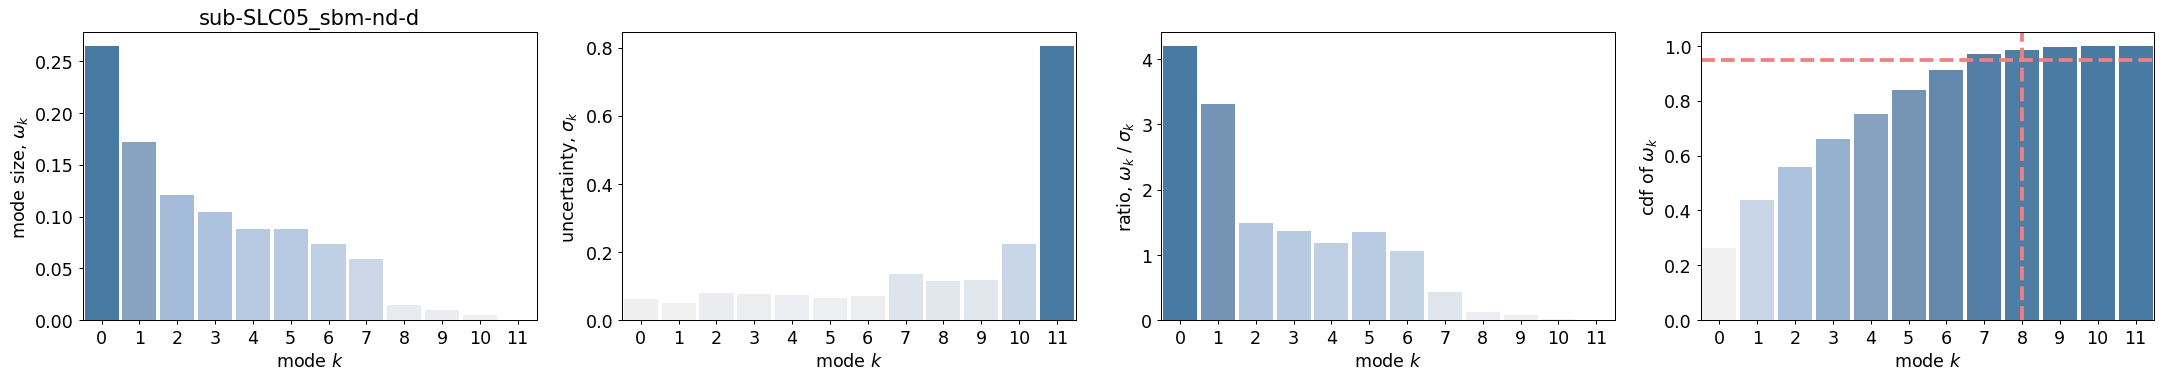

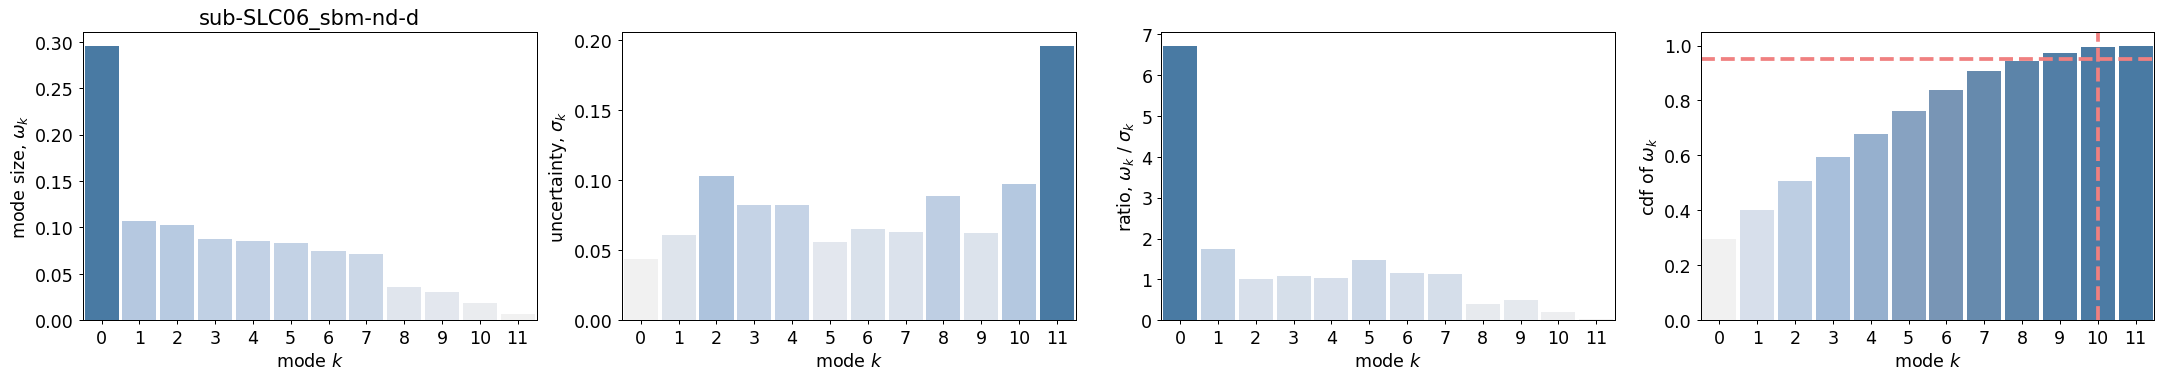

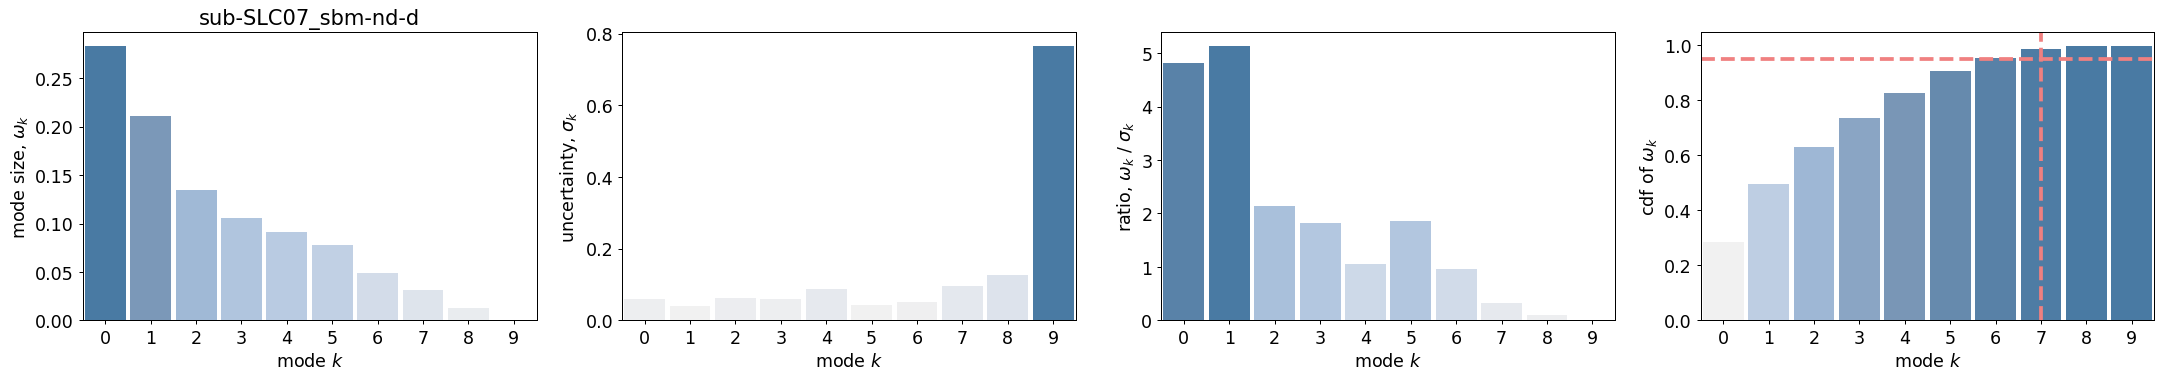

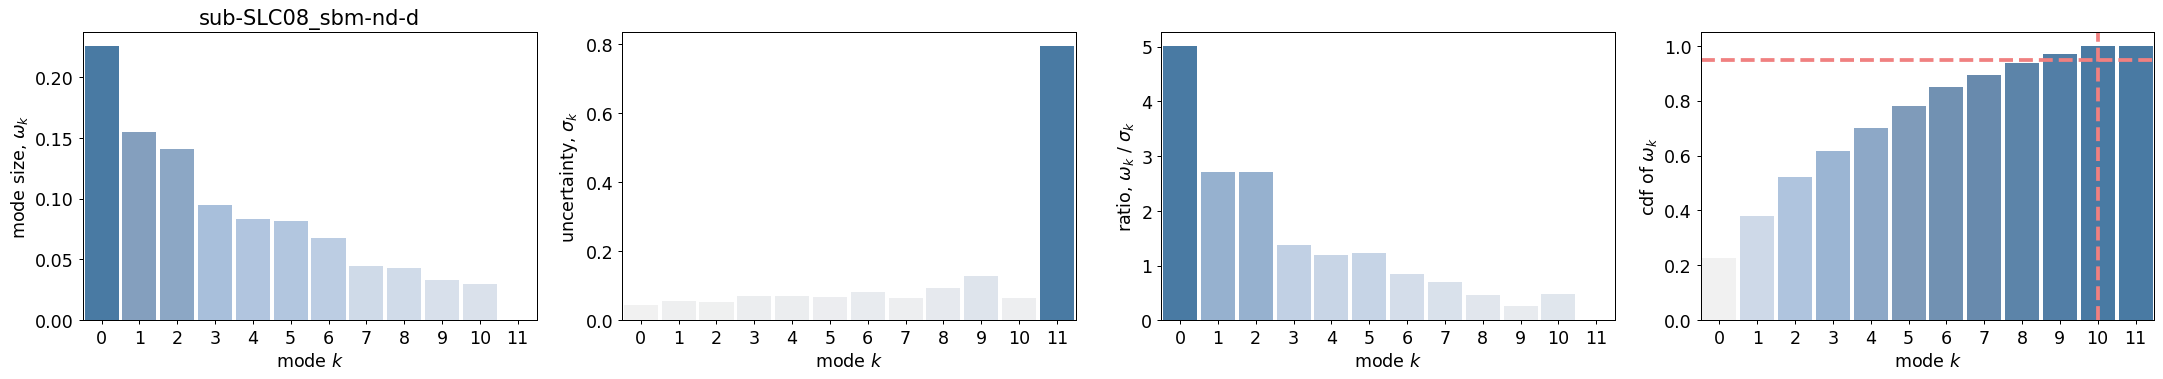

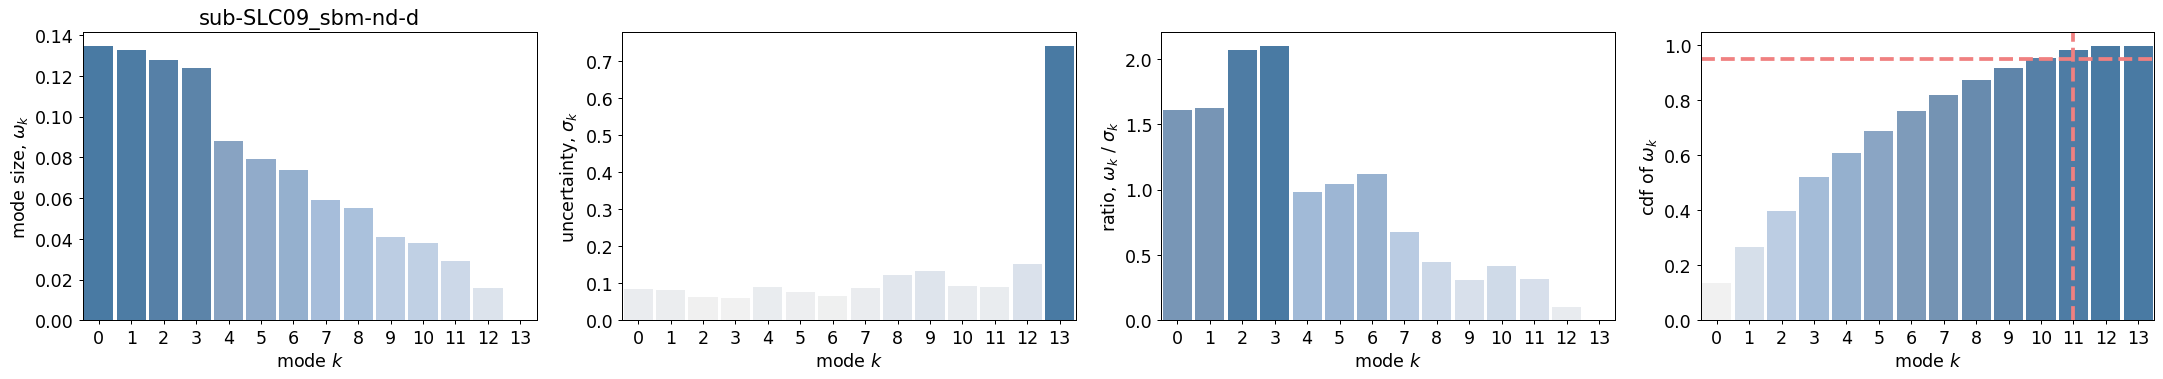

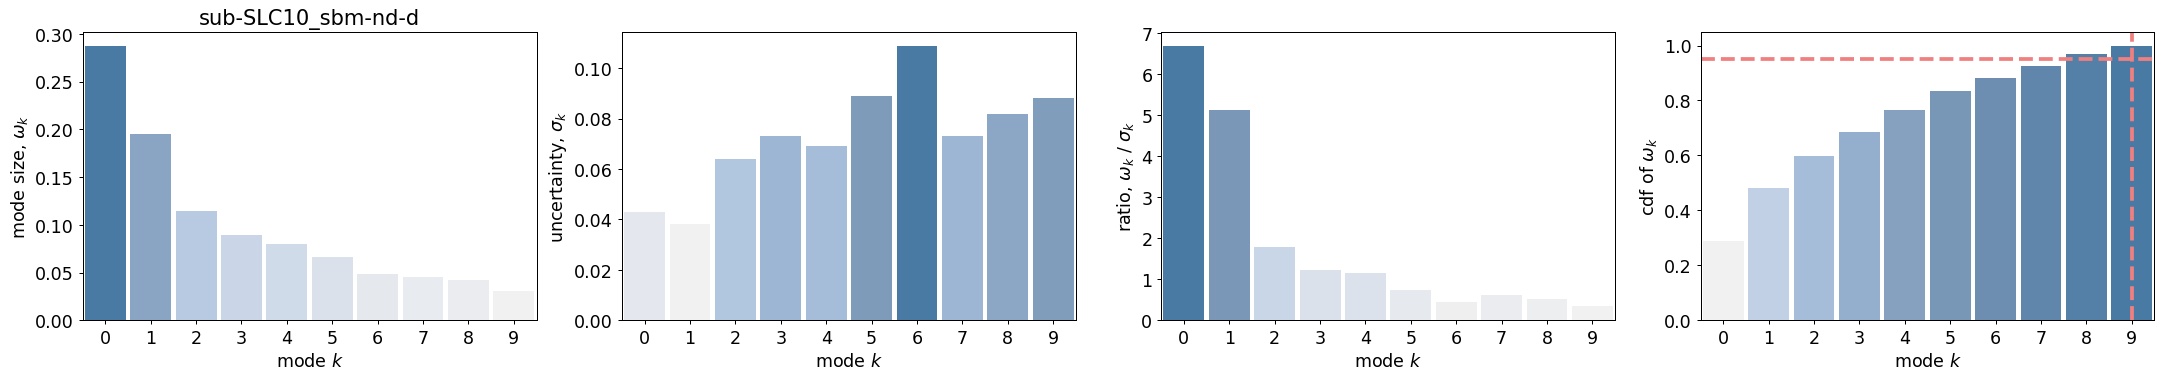

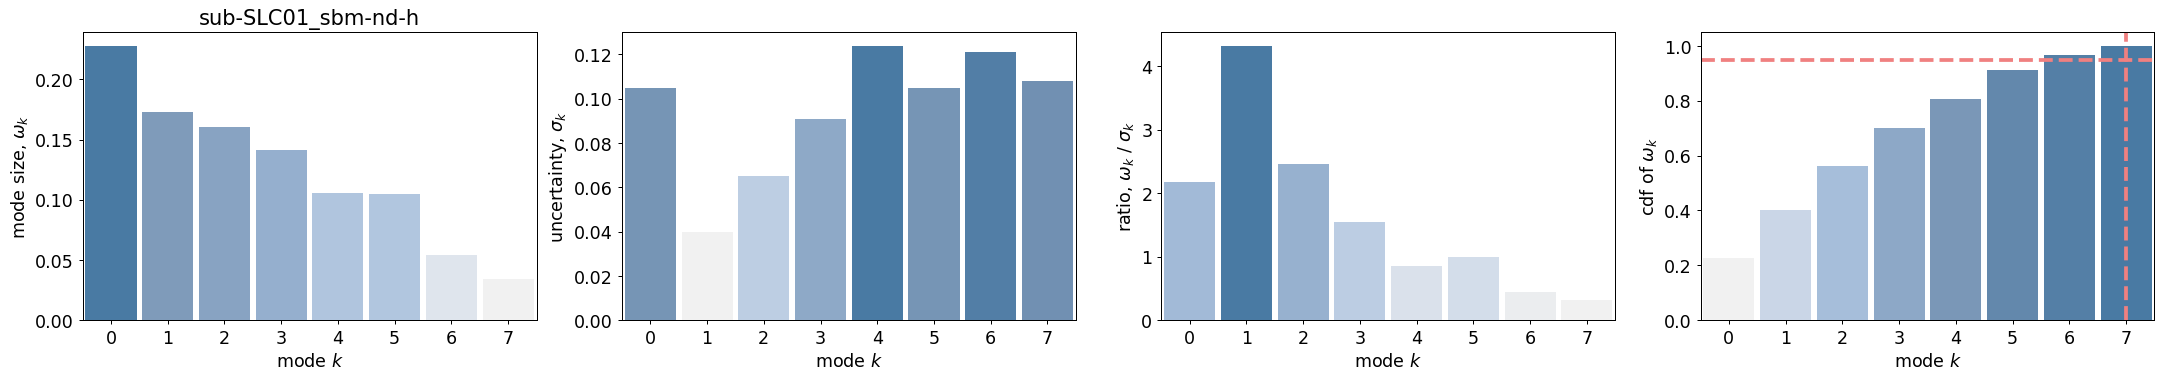

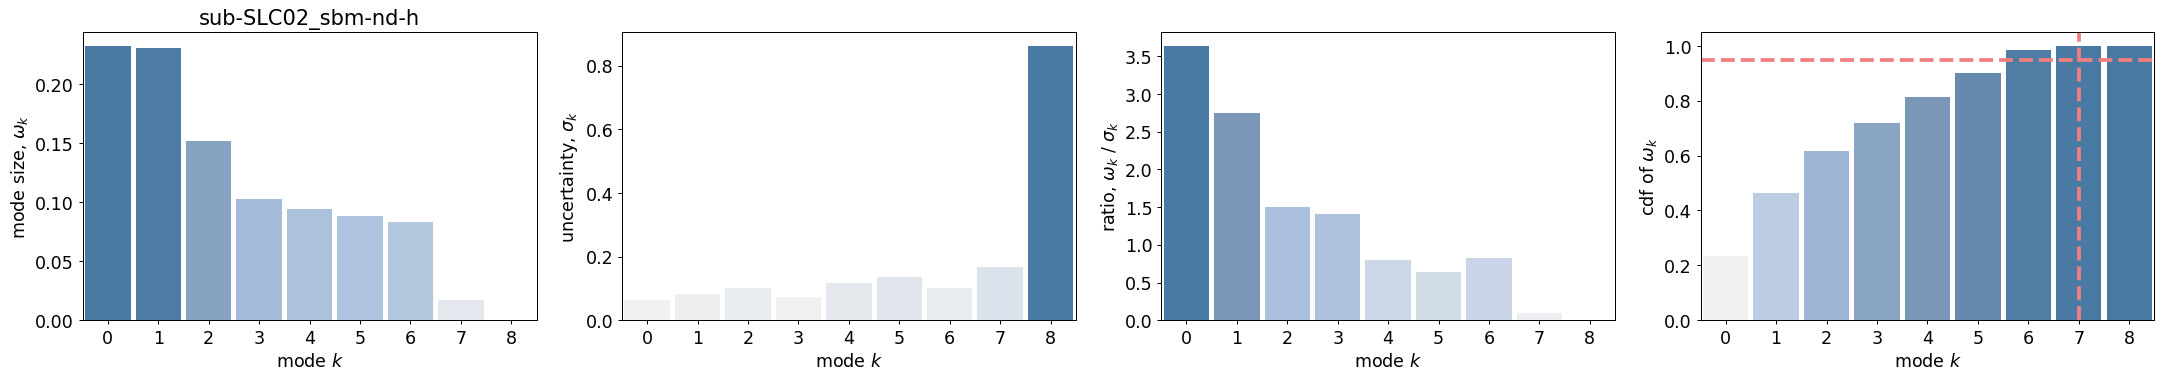

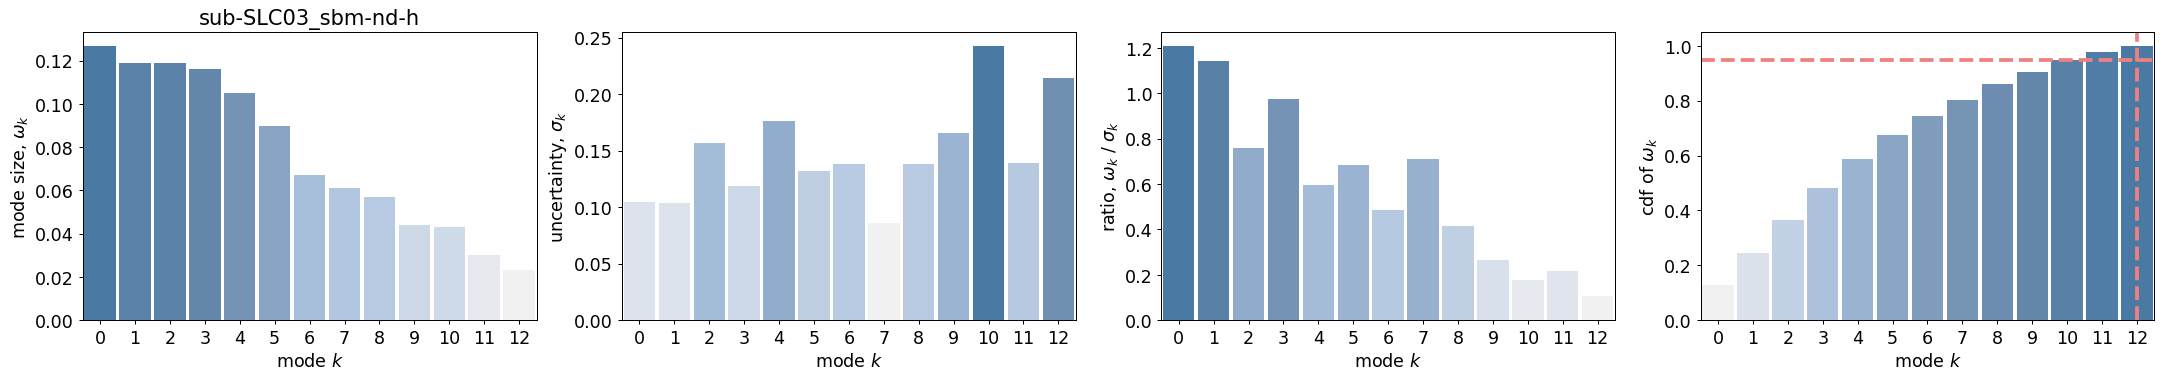

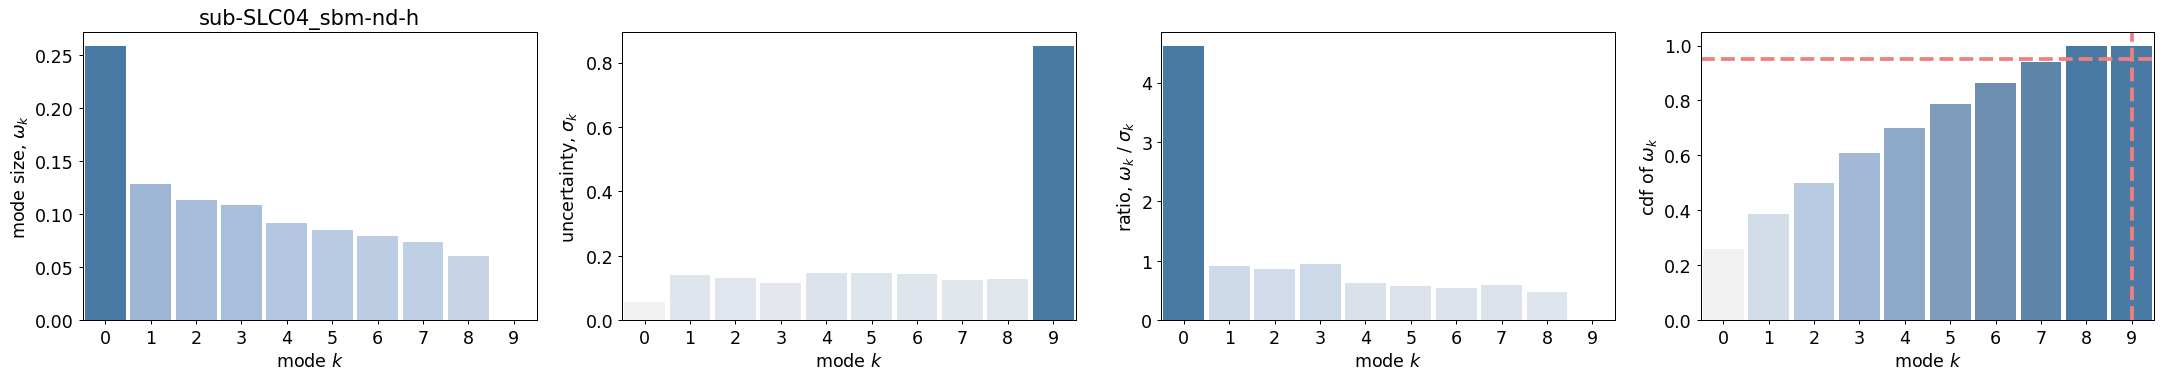

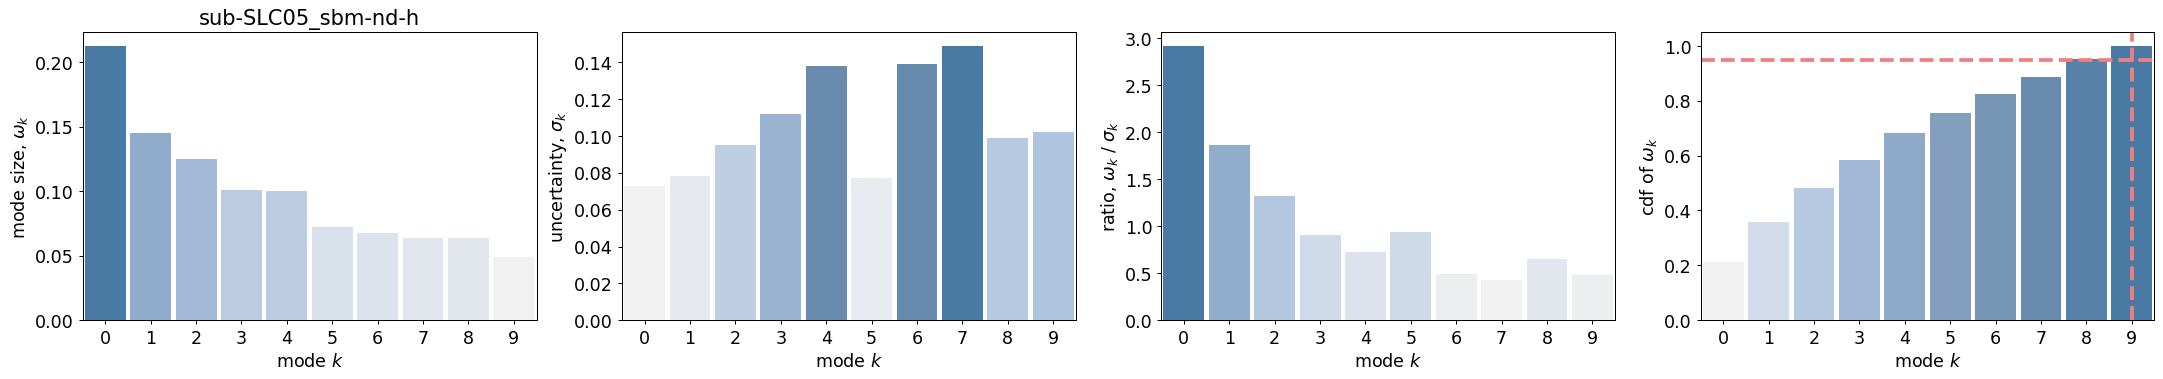

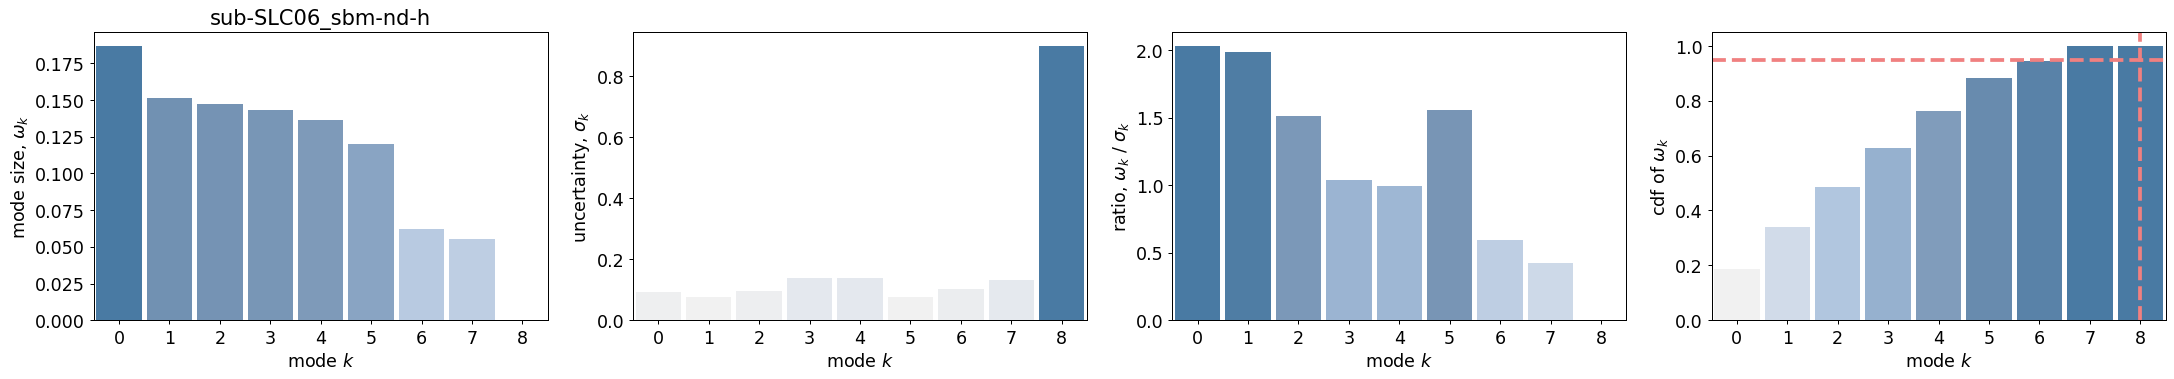

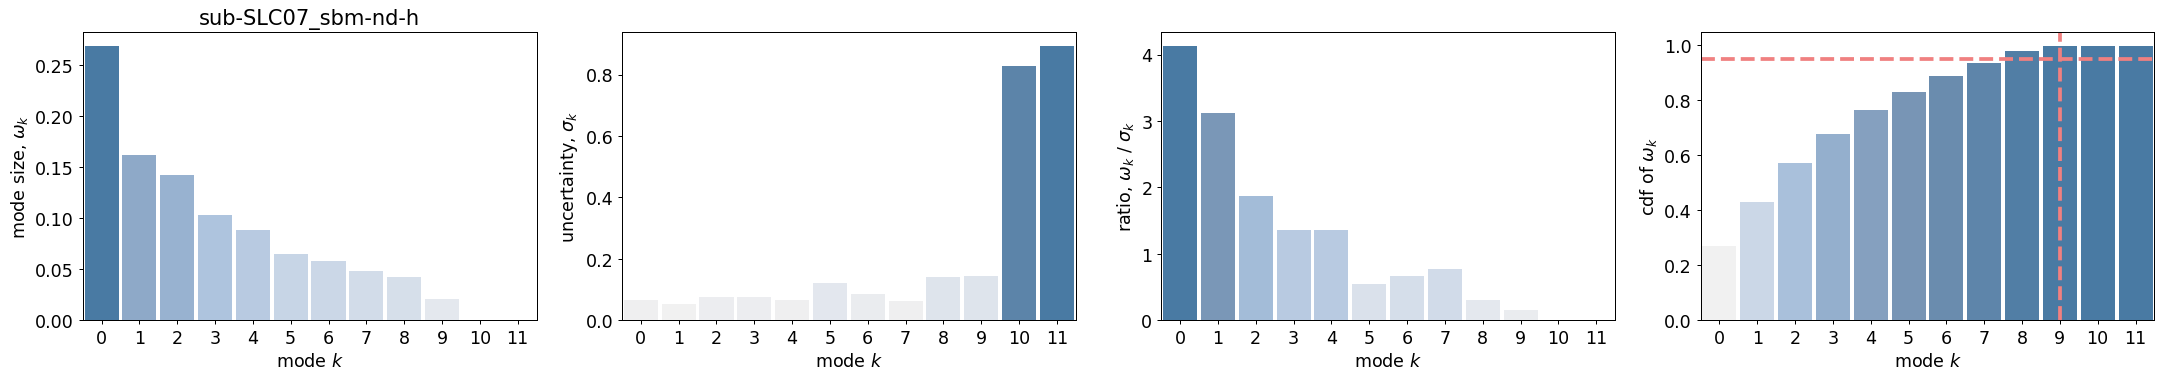

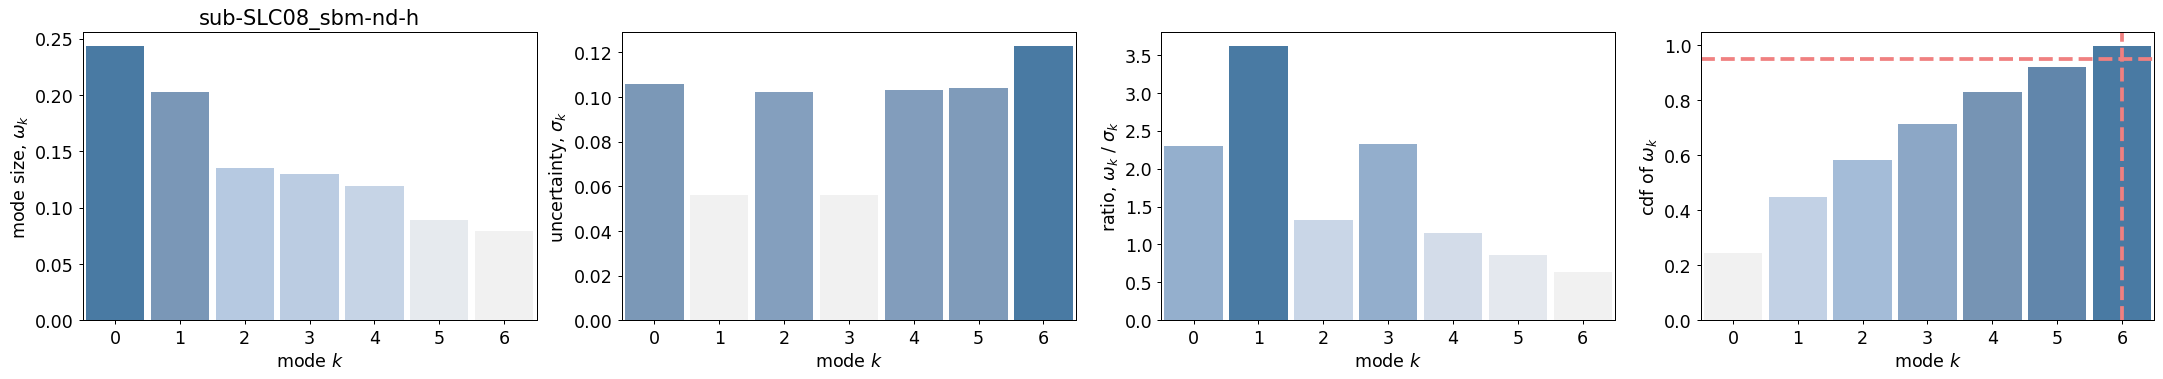

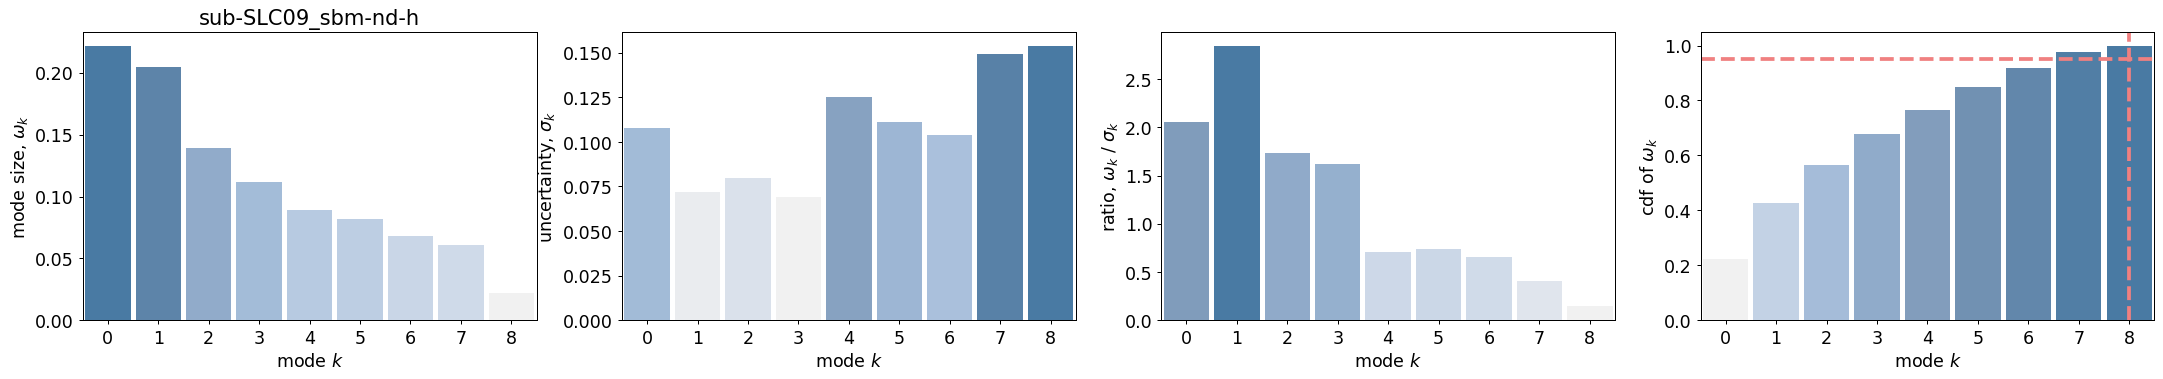

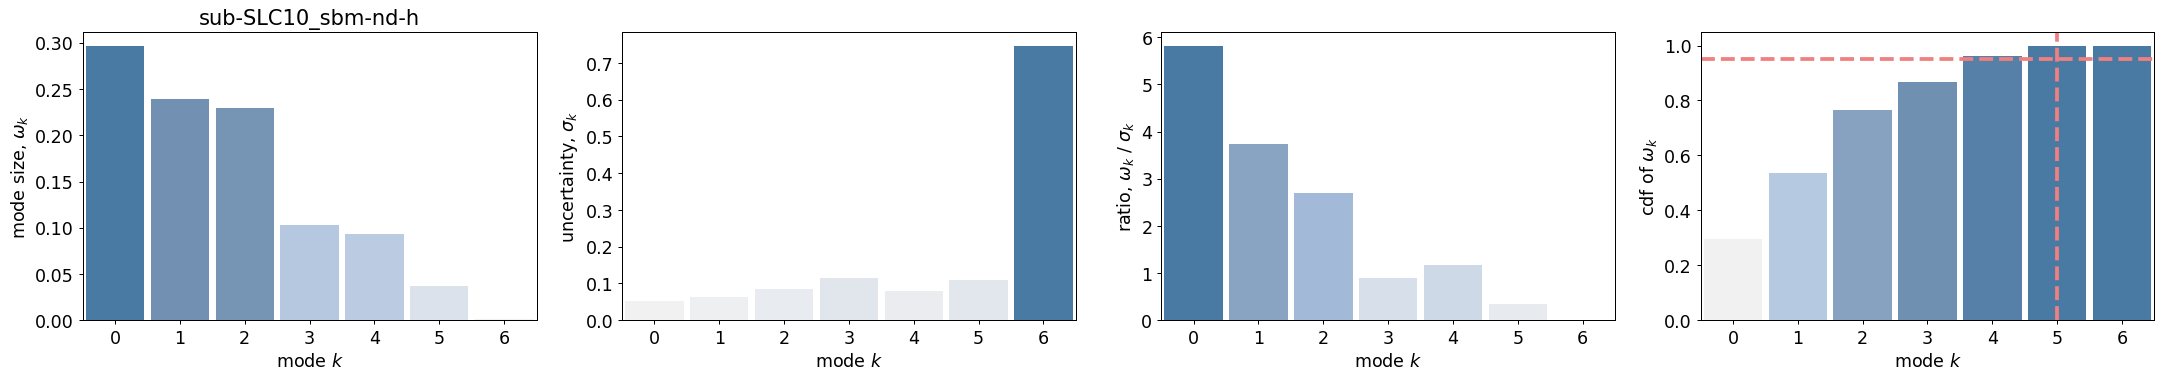

In [7]:
for sbm in sbms_list[:]:
    args.dc, args.sbm = sbm

    args.nested = args.sbm == 'h'

    args.force_niter = 40000
    args.num_draws = int((1/2) * args.force_niter)

    def sbm_name(args):
        dc = f'dc' if args.dc else f'nd'
        dc = f'' if args.sbm in ['a'] else dc
        file = f'sbm-{dc}-{args.sbm}'
        return file

    SBM = sbm_name(args)
    print(SBM)


    df_files = sorted(glob.glob(f'{ESTIM_path}/individual/*/partition-modes-group-aligned/{SBM}/desc-marginals-df.pkl', recursive=True))
    display(df_files)
    for df_file in tqdm(df_files):
        with open(f'{df_file}', 'rb') as f:
            indiv_marginals_df = pickle.load(f)
        sub = df_file.split('/')[-4].split('-')[-1]
        
        modes_df = indiv_marginals_df[indiv_marginals_df['level'] == 0] if args.sbm in ['h'] else indiv_marginals_df
        
        fig, suff_num_modes = plot_mode_summaries(
            args, 
            SBM, 
            modes_df=modes_df, 
            sub=sub,
        )
        fig.savefig(f'{ESTIM_path}/individual/sub-{sub}/partition-modes-group-aligned/{SBM}/desc-mode-summaries.pdf')
        np.savetxt(f'{ESTIM_path}/individual/sub-{sub}/partition-modes-group-aligned/{SBM}/desc-suff-num-modes.txt', [suff_num_modes], fmt='%02d')
        # break
    # break